# Contents

__[1. Dataset](#DATASET)__  

__[2. Exploratory data analysis  ](#EXPLORATORY-DATA-ANALYSIS)__  

__[3. Model Selection](#MODEL-SELECTION)__  
    [3.1. Individual machine learning models](#Individual-machine-learning-models)  
    [3.1.1. K-Nearest Neighbors](#K-Nearest-Neighbors)  
    [3.1.2. SVM](#SVM) 
    [3.2. Ensembles and boosting](#Ensembles-and-boosting)  
    [3.2.1. XGBoost](#XGBoost)  
    [3.2.2. Gradient boosting](#Gradient-boosting)  
    [3.2.3. LightGBM](#LightGBM)  
    [3.2.4. AdaBoost](#AdaBoost)  
    [3.2.5. Random Forest](#Random-Forest)  
    [⁽ⁿᵉʷ⁾3.3. Deep Learning](#Deep-Learning)  
    [⁽ⁿᵉʷ⁾3.3.1. CNN](#CNN)  
    [⁽ⁿᵉʷ⁾3.3.2. LSTM](#LSTM)  
    [⁽ⁿᵉʷ⁾3.3.3. Bidirectional LSTM](#Bidirectional-LSTM)  
    
__[4. Resampling](#Resamling)__  
    [⁽ⁿᵉʷ⁾4.1. SMOTE-Tomek Links Method](#SMOTE-Tomek-Links-Method)  
    [⁽ⁿᵉʷ⁾4.1.1 SMOTE-Tomek Links for SVM](#SMOTE-Tomek-Links-for-SVM)  
    [⁽ⁿᵉʷ⁾4.1.2 SMOTE-Tomek Links for LightGBM](#SMOTE-Tomek-Links-for-LightGBM)  
    [⁽ⁿᵉʷ⁾4.1.3 SMOTE-Tomek Links for Random Forest](#SMOTE-Tomek-Links-for-Random-Forest)  
    [⁽ⁿᵉʷ⁾4.2. SMOTE-ENN Method](#SMOTE-ENN-Method)  
    [⁽ⁿᵉʷ⁾4.1. SMOTE-ENN Method](#SMOTE-ENN-Method)  
    [⁽ⁿᵉʷ⁾4.1.1 SMOTE-ENN for SVM](#SMOTE-ENN-for-SVM)  
    [⁽ⁿᵉʷ⁾4.1.2 SMOTE-ENN for LightGBM](#SMOTE-ENN-for-LightGBM)  
    [⁽ⁿᵉʷ⁾4.1.3 SMOTE-ENN for Random Forest](#SMOTE-ENN-for-Random-Forest)  

__[⁽ⁿᵉʷ⁾5. Summary of the results](#Summary-of-the-results)__  
    [⁽ⁿᵉʷ⁾5.1. Metrics over all classes](#Metrics-over-all-classes)  
    [⁽ⁿᵉʷ⁾5.2. Metrics per class for original dataset](#Metrics-per-class-for-original-dataset)  
    [⁽ⁿᵉʷ⁾5.3. Metrics per class for resampled dataset](#Metrics-per-class-for-resampled-dataset)  

__[6. TO DO](#TO-DO)__  


In [2]:
import numpy as np 
import pandas as pd 

import random
import itertools
from importlib import reload
from datetime import datetime

import matplotlib.pyplot as plt

from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV

from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, auc
from sklearn.metrics import precision_recall_curve

from imblearn.combine import SMOTEENN, SMOTETomek
from imblearn.under_sampling import EditedNearestNeighbours, TomekLinks

# my packages
import pipelitools as t

SMALL_SIZE = 8
MEDIUM_SIZE = 10
BIGGER_SIZE = 14

plt.rc('font', size=BIGGER_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=BIGGER_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=BIGGER_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=BIGGER_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=BIGGER_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title


# DATASET  

The dataset is the MIT-BIH Arrhythmia Dataset:  
https://www.kaggle.com/gregoiredc/arrhythmia-on-ecg-classification-using-cnn  
https://archive.physionet.org/physiobank/database/html/mitdbdir/intro.htm

- Number of Samples: 109446
- Number of Categories: 5
- Sampling Frequency: 125Hz
- Data Source: Physionet's MIT-BIH Arrhythmia Dataset
- Classes: ['N': 0, 'S': 1, 'V': 2, 'F': 3, 'Q': 4]  
(N - Normal beat, S - Supraventricular premature beat, V - Premature ventricular contraction, F - Fusion of ventricular and normal beat, Q - Unclassifiable beat)

Each row is one beat taken from the original source (represents 10 seconds of data)

__Task:__ multiclass classification

In [3]:
import os
for dirname, _, filenames in os.walk('../data'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
        
# mitbih data
df_train = pd.read_csv('./data/mitbih_train.csv', header=None)
df_test = pd.read_csv('./data/mitbih_test.csv', header=None)

# combined df
train = df_train.rename(columns={187:'y'})
test = df_test.rename(columns={187:'y'})

# training data
X_train = train[train.columns[:-1]]
y_train = train[train.columns[-1]]

# testing data
X_test = test[test.columns[:-1]]
y_test = test[test.columns[-1]]

__[top](#Contents)__  

# EXPLORATORY DATA ANALYSIS

- The observations are skewed.
- Normal heartbeat is the most popular class. Deviations from this class are scarce, especially for class 1 (S - Supraventricular premature beat) and 3 (F - Fusion of ventricular and normal beat) and require more attention.

NaNs:  []
Unique formats:  [dtype('float64')]
Possible categorical variables (<10 unique values):  []
Min value < 0:  []
Observations per class:
 0    72471
1     2223
2     5788
3      641
4     6431
Name: y, dtype: int64
Plotting distributions of variables against normal distribution


C:\Users\nastiag67\Anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
C:\Users\nastiag67\Anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
C:\Users\nastiag67\Anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibili

C:\Users\nastiag67\Anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
C:\Users\nastiag67\Anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
C:\Users\nastiag67\Anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibili

C:\Users\nastiag67\Anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
C:\Users\nastiag67\Anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
C:\Users\nastiag67\Anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibili

C:\Users\nastiag67\Anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
C:\Users\nastiag67\Anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
C:\Users\nastiag67\Anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibili

C:\Users\nastiag67\Anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
C:\Users\nastiag67\Anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
C:\Users\nastiag67\Anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibili

C:\Users\nastiag67\Anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
C:\Users\nastiag67\Anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
C:\Users\nastiag67\Anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibili

C:\Users\nastiag67\Anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
C:\Users\nastiag67\Anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
C:\Users\nastiag67\Anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibili

C:\Users\nastiag67\Anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
C:\Users\nastiag67\Anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
C:\Users\nastiag67\Anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibili

C:\Users\nastiag67\Anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
C:\Users\nastiag67\Anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
C:\Users\nastiag67\Anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibili

ValueError: Image size of 9000x168300 pixels is too large. It must be less than 2^16 in each direction.

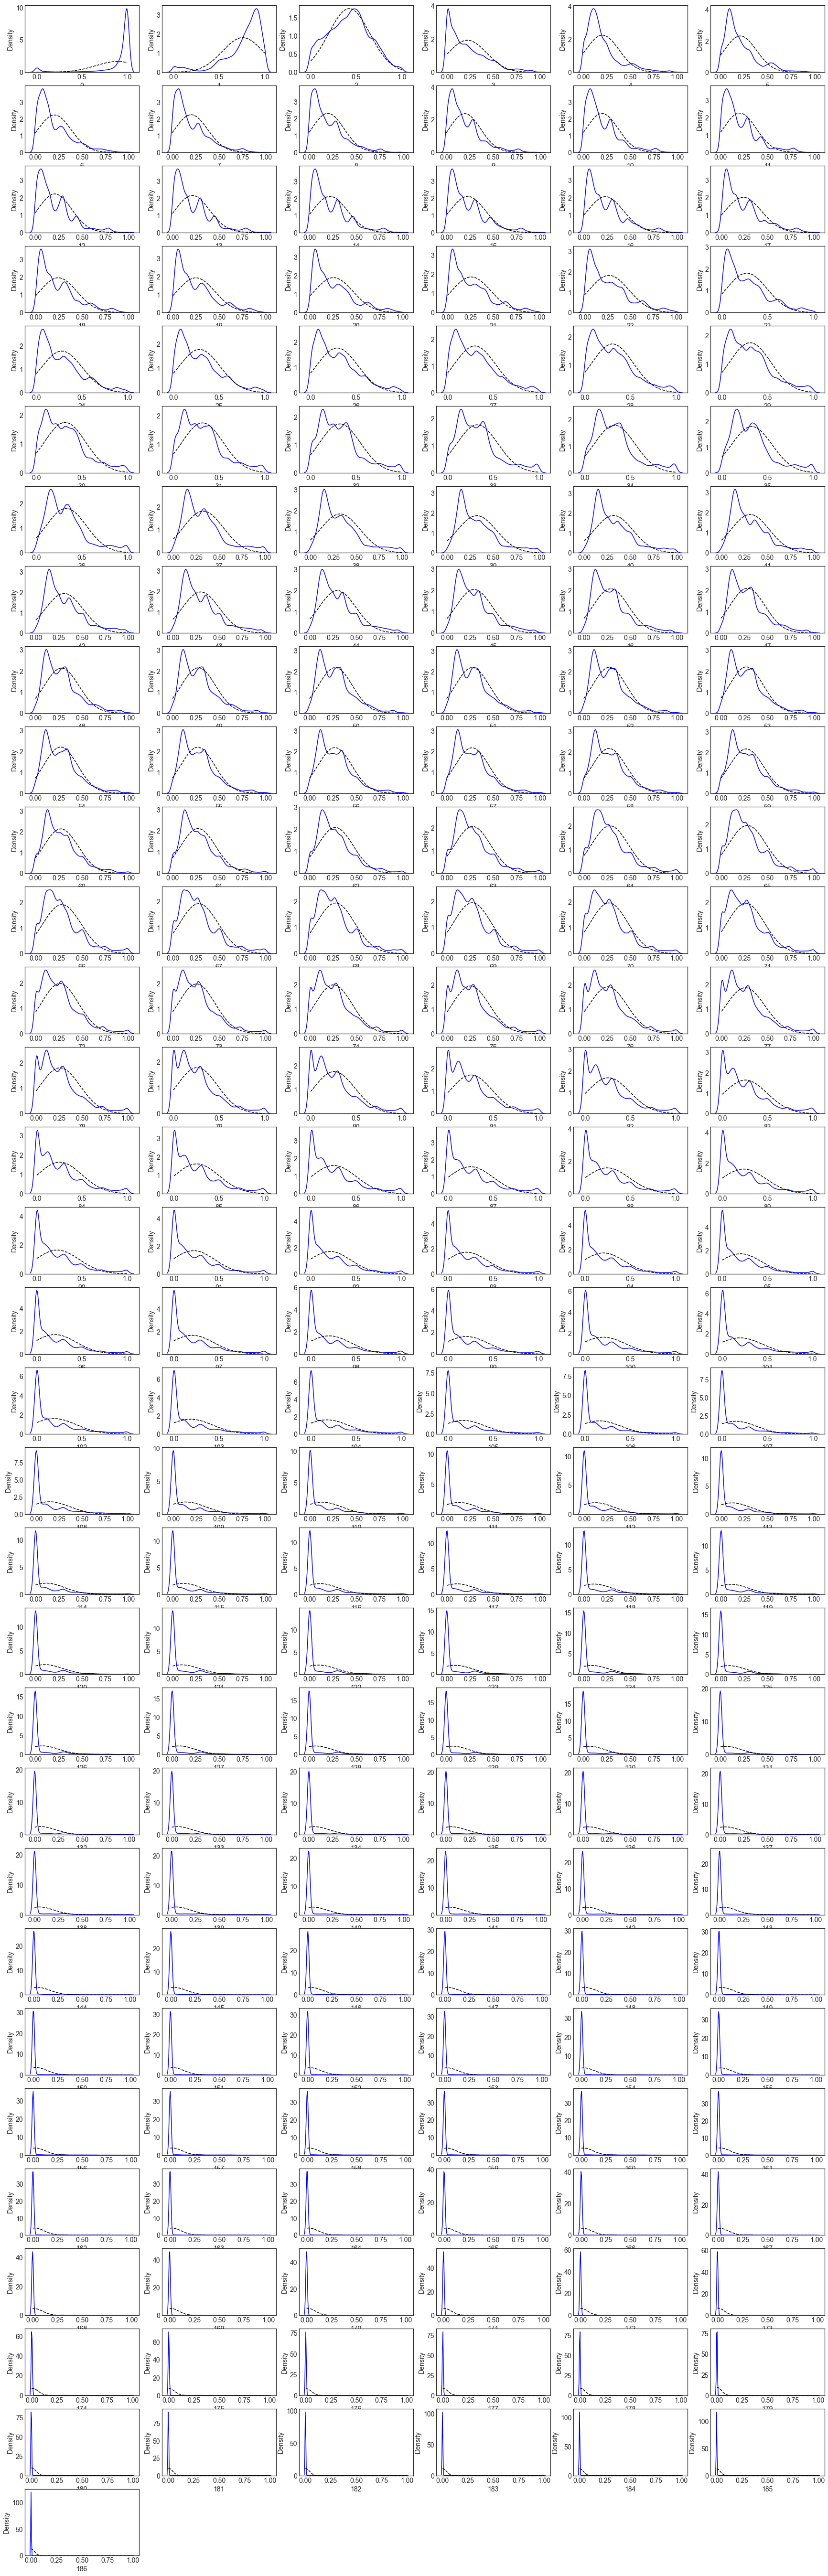

In [12]:
from pipelitools.preprocessing import eda

cls_df = eda.Dataset(X_train)
cls_df.get_summary(
    y=y_train,
    nan=True,
    formats=True,
    categorical=True,
    min_less_0=True,
    class_counts=True,
    check_normdist=True,
    plot_boxplots=False)
plt.savefig(f"dist.png", dpi=300, bbox_inches='tight')


### Observations per class

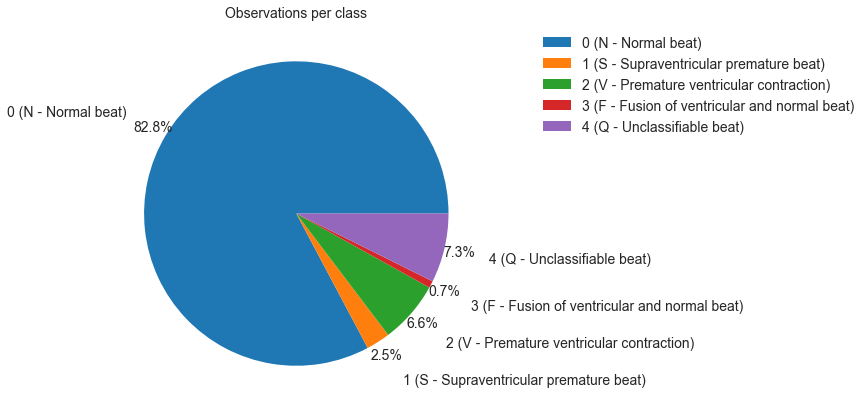

In [15]:
labels = ['0 (N - Normal beat)',
          '1 (S - Supraventricular premature beat)',
          '2 (V - Premature ventricular contraction)',
          '3 (F - Fusion of ventricular and normal beat)',
          '4 (Q - Unclassifiable beat)']
 
plt.figure(figsize=(10, 7))
plt.pie(y_train.astype(int).value_counts().sort_index(), labels=labels, autopct='%1.1f%%', pctdistance=1.1, labeldistance=1.3)
plt.title('Observations per class')
plt.legend( bbox_to_anchor=(2, 1), loc='upper right')
plt.savefig(f"pie.png", dpi=300, bbox_inches='tight')
plt.show()

### Examples from different classes

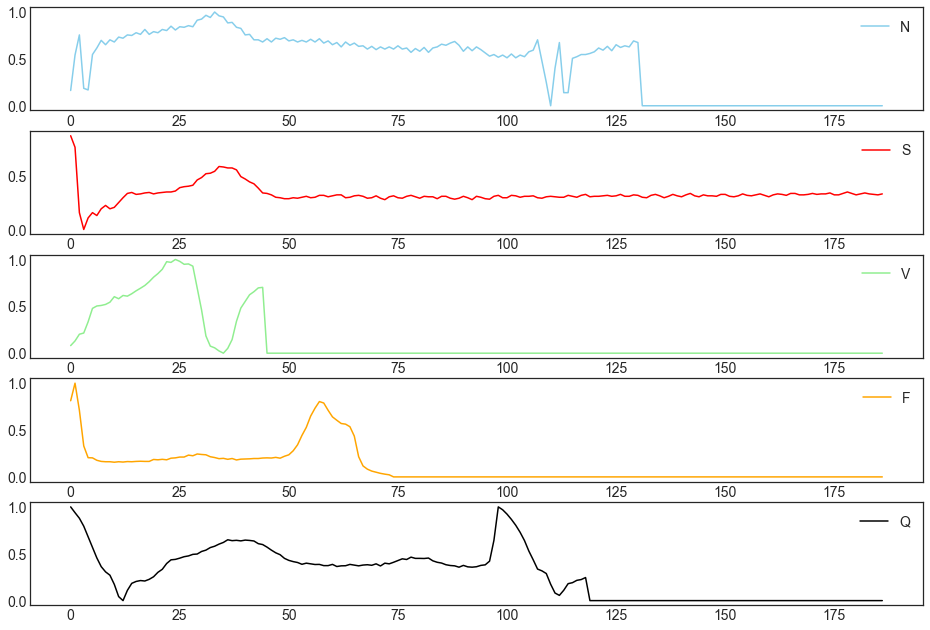

In [16]:
# sample one observation
r_sample = df_train.groupby(187, group_keys=False).apply(lambda train_df: train_df.sample(1, random_state=42))

# plot 
fig, axes = plt.subplots(5, 1, figsize=(16, 11))
leg = iter(['N - Normal beat',
 'S - Supraventricular premature beat',
 'V - Premature ventricular contraction',
 'F - Fusion of ventricular and normal beat',
 'Q - Unclassifiable beat'])
colors = iter(['skyblue', 'red', 'lightgreen', 'orange', 'black'])
for i, ax in enumerate(axes.flatten()):
    ax.plot(r_sample.iloc[i, :187], color=next(colors))
#     print(next(leg))
    ax.legend(next(leg))
plt.savefig(f"samples.png", dpi=300, bbox_inches='tight')
plt.show()


__[top](#Contents)__  

# MODEL SELECTION  

__The problem__:  
Although the accuracy is pretty high (90%), recall is very low for some classes (1 (S - Supraventricular premature beat) and 3 (F - Fusion of ventricular and normal beat)). Since the dataset is unbalanced (normal beat represents the majority of the datapoints), accuracy is not a good measure for assessing model performance, because we should focus on positive cases for these classes if we wish to identify the disease. 

So, we need to improve __recall__, the ability of a model to find all relevant cases within a dataset, while keeping the precision at an appropriate level.

A __macro-average__ will compute the metric independently for each class and then take the average (hence treating all classes equally), whereas a __micro-average__ will aggregate the contributions of all classes to compute the average metric. Macro leads to a lower result since it doesn't account for the number of samples in the minority class.

In [4]:
#train validation split
X_train, X_val, y_train, y_val = train_test_split(train.iloc[:,:-1], train.iloc[:,-1], 
                                                    test_size=0.2, random_state=42)

import multiprocessing
n_jobs=multiprocessing.cpu_count()  # 56

#my package
import pipelitools as t
reload(t)
from pipelitools.models import models as m
from pipelitools.models import metrics as mt
reload(mt)

# Create the pipeline
from sklearn.preprocessing import StandardScaler

cls_models = m.Model(X_train, y_train, X_val, y_val)


## Individual machine learning models

- Original dataset was used (no feature selection, no sampling).
- Models which were compared: Naive Bayes, Logistic regression, SVM, kNN, Decision trees.
- Best performing models based on recall: SVM, kNN, DT.

__[top](#Contents)__  

## K-Nearest Neighbors

Fitting 5 folds for each of 20 candidates, totalling 100 fits
Mean cross-validated score of the best_estimator: 0.8466
     Parameter Tuned value
0  n_neighbors           4
1            p           1
2      weights    distance
F1-score: 0.8893
Precision: 0.9254
Recall: 0.8596
Accuracy on train data: 1.0
Accuracy on test data: 0.9769


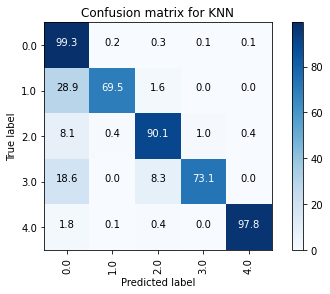

Wall time: 17min 41s


In [4]:
%%time

from sklearn.neighbors import KNeighborsClassifier
name = 'KNN'
model = KNeighborsClassifier(
    n_jobs=56,
)

steps=[]

parameters = {
    'KNN__n_neighbors': np.arange(3, 8, 1),
    'KNN__weights': ['uniform', 'distance'],
    'KNN__p': [1, 2]
}


model_knn, y_pred_knn = cls_models.checkmodel(
                                    name,
                                    model,
                                    steps=steps,
                                    parameters=parameters,
                                    average='macro',
                                    multiclass=True,
                                    metric='recall',
                                    randomized_search=False,
                                    nfolds=5,
                                    n_jobs=56,
                                    save_pickle=True,
                                    verbose=3
                                    )


              precision    recall  f1-score   support

         0.0       0.98      0.99      0.99     18118
         1.0       0.88      0.67      0.76       556
         2.0       0.95      0.92      0.93      1448
         3.0       0.79      0.67      0.73       162
         4.0       0.99      0.97      0.98      1608

    accuracy                           0.98     21892
   macro avg       0.92      0.84      0.88     21892
weighted avg       0.98      0.98      0.98     21892



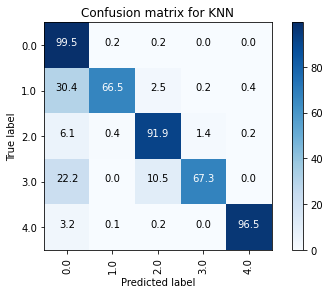

In [100]:
# check the metrics on testing dataset
mt.metrics_report(model_knn, 'KNN', X_test, y_test, y_train, data='test')

__[top](#Contents)__  

## SVM

Fitting 5 folds for each of 15 candidates, totalling 75 fits
Mean cross-validated score of the best_estimator: 0.9175
      Parameter Tuned value
0             C           1
1  class_weight    balanced
2         gamma         0.5
F1-score: 0.8157
Precision: 0.7602
Recall: 0.9312
Accuracy on train data: 0.9867
Accuracy on test data: 0.9568


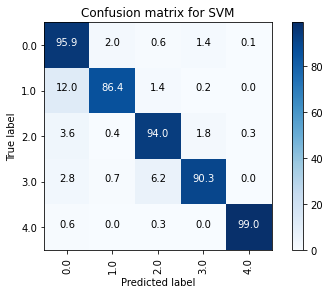

Wall time: 1h 24min 50s


In [5]:
%%time

name = 'SVM'
model = SVC()

steps=[]

parameters = {
    'SVM__C': [1, 10, 50],
    # Regularization - tells the SVM optimization how much error is bearable
    # control the trade-off between decision boundary and misclassification term
    # smaller value => small-margin hyperplane
    # 'SVM__kernel': ['linear', 'poly', 'rbf', 'sigmoid'],  # VERY long pls don't
    # 'SVM__degree': [3],
    'SVM__gamma': [0.1, 0.5, 0.07, 'scale', 'auto'],  # scale
    'SVM__class_weight': ['balanced'],  # None
    }

model_svm, y_pred_svm = cls_models.checkmodel(
                                    name,
                                    model,
                                    steps=steps,
                                    parameters=parameters,
                                    average='macro',
                                    multiclass=True,
                                    metric='recall',
                                    randomized_search=False,
                                    nfolds=5,
                                    n_jobs=56,
                                    save_pickle=True,
                                    verbose=3
                                    )


              precision    recall  f1-score   support

         0.0       0.99      0.96      0.97     18118
         1.0       0.52      0.80      0.63       556
         2.0       0.92      0.94      0.93      1448
         3.0       0.36      0.90      0.51       162
         4.0       0.98      0.98      0.98      1608

    accuracy                           0.95     21892
   macro avg       0.75      0.91      0.80     21892
weighted avg       0.97      0.95      0.96     21892



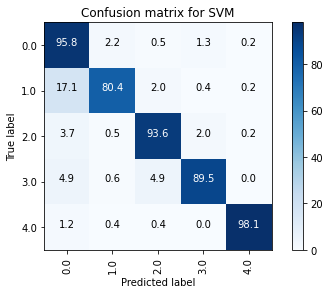

In [103]:
# check the metrics on testing dataset
mt.metrics_report(model_svm[0], 'SVM', X_test, y_test, y_train, data='test')

__[top](#Contents)__  

## Ensembles and boosting

### XGBoost

Fitting 5 folds for each of 324 candidates, totalling 1620 fits
Mean cross-validated score of the best_estimator: 0.8518
            Parameter Tuned value
0               alpha           0
1                 eta         0.5
2               gamma           0
3              lambda           1
4           max_depth          10
5    min_child_weight         0.5
6   num_parallel_tree           1
7     sampling_method     uniform
8    scale_pos_weight         0.3
9           subsample         0.7
10        tree_method        auto 

              precision    recall  f1-score   support

         0.0       0.98      1.00      0.99     14579
         1.0       0.96      0.70      0.81       426
         2.0       0.96      0.92      0.94      1112
         3.0       0.92      0.74      0.82       145
         4.0       0.99      0.98      0.98      1249

    accuracy                           0.98     17511
   macro avg       0.96      0.87      0.91     17511
weighted avg       0.98      0.98  

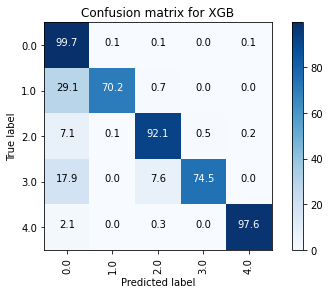

In [4]:
%%time

import xgboost as xgb

name = 'XGB'
model = xgb.XGBClassifier(    
    seed=42,
    verbosity=0,
    use_label_encoder=False,
    objective='multi:softmax',
    num_class=5,
#     eval_metric='mlogloss',
    eval_metric='merror',
)

steps=[]

parameters = {    
    'XGB__eta': [0.05, 0.3, 0.5],  # 0.3
    'XGB__gamma': [0, 1, 5],  # 0
    'XGB__max_depth': [3, 6, 10],  # 6
    'XGB__min_child_weight': [0.5, 1],  # 1
    'XGB__subsample': [0.7, 1],  # 1
    'XGB__sampling_method': ['uniform'],  # uniform
#     'XGB__colsample_bytree': [0.7],  # 1
    'XGB__lambda': [1],  # 1
    'XGB__alpha': [0],  # 0
    'XGB__tree_method': ['auto'],  # auto
    'XGB__scale_pos_weight': [0.3, 0.7, 1],  # 1
#     'XGB__predictor': ['cpu_predictor'],  # auto
    'XGB__num_parallel_tree': [1],  # 1
}

model_xgb, y_pred_xgb = cls_models.checkmodel(
                                    name,
                                    model,
                                    steps=steps,
                                    parameters=parameters,
                                    average='macro',
                                    multiclass=True,
                                    metric='recall',
                                    randomized_search=False,
                                    nfolds=5,
                                    n_jobs=56,
                                    save_pickle=False,
                                    verbose=3
                                    )


              precision    recall  f1-score   support

         0.0       0.98      1.00      0.99     18118
         1.0       0.97      0.67      0.79       556
         2.0       0.97      0.92      0.95      1448
         3.0       0.87      0.69      0.77       162
         4.0       0.99      0.97      0.98      1608

    accuracy                           0.98     21892
   macro avg       0.96      0.85      0.90     21892
weighted avg       0.98      0.98      0.98     21892



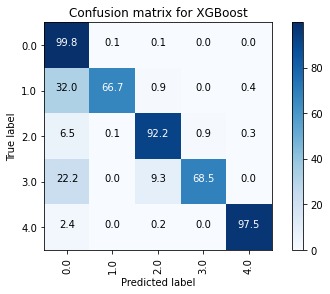

In [6]:
# check the metrics on testing dataset
mt.metrics_report(model_xgb, 'XGBoost', X_test, y_test, y_train, data='test')

__[top](#Contents)__  

### Gradient Boosting

Fitting 5 folds for each of 108 candidates, totalling 540 fits
Mean cross-validated score of the best_estimator: 0.8
                   Parameter   Tuned value
0                  criterion  friedman_mse
1              learning_rate           0.1
2                       loss      deviance
3                  max_depth             5
4             max_leaf_nodes          None
5      min_impurity_decrease             0
6           min_samples_leaf             1
7          min_samples_split             2
8   min_weight_fraction_leaf             0
9               n_estimators           500
10          n_iter_no_change             5
11                 subsample             1
12       validation_fraction           0.1
F1-score: 0.8581
Precision: 0.9073
Recall: 0.8192
Accuracy on train data: 0.9425
Accuracy on test data: 0.9718


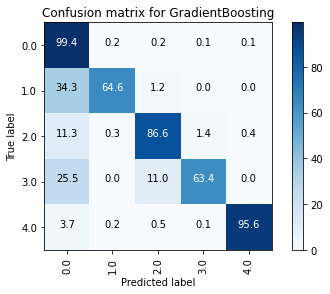

Wall time: 7h 22min 49s


In [4]:
%%time
from sklearn.ensemble import GradientBoostingClassifier

name='GradientBoosting'
model = GradientBoostingClassifier(random_state=42)

steps=[]

parameters = {
    'GradientBoosting__loss': ['deviance'],  # 'deviance'
    'GradientBoosting__learning_rate': [0.1, 0.5, 0.01],  # 0.1
    'GradientBoosting__n_estimators': [100, 500, 50],  # 100
    'GradientBoosting__subsample': [1, 0.5, 0.7],  # 1
    'GradientBoosting__criterion': ['friedman_mse'],  # 'friedman_mse'
    'GradientBoosting__min_samples_split': [2, 5],  # 2
    'GradientBoosting__min_samples_leaf': [1],  # 1
    'GradientBoosting__min_weight_fraction_leaf': [0],  # 0
    'GradientBoosting__max_depth': [3, 5],  # 3
    'GradientBoosting__min_impurity_decrease': [0],  # 0
#     'GradientBoosting__max_features': [None, 'auto', 'sqrt', 'log2'],  # None
    'GradientBoosting__max_leaf_nodes': [None],  # None
    'GradientBoosting__validation_fraction': [0.1],  # 0.1
    'GradientBoosting__n_iter_no_change': [5],  # 0
}

model_gb, y_pre_gb = cls_models.checkmodel(
                                    name,
                                    model,
                                    steps=steps,
                                    parameters=parameters,
                                    average='macro',
                                    multiclass=True,
                                    metric='recall',
                                    randomized_search=False,
                                    nfolds=5,
                                    n_jobs=56,
                                    save_pickle=True,
                                    verbose=3
                                    )


              precision    recall  f1-score   support

         0.0       0.97      0.99      0.98     18118
         1.0       0.88      0.61      0.72       556
         2.0       0.95      0.86      0.91      1448
         3.0       0.61      0.62      0.61       162
         4.0       0.99      0.95      0.97      1608

    accuracy                           0.97     21892
   macro avg       0.88      0.81      0.84     21892
weighted avg       0.97      0.97      0.97     21892



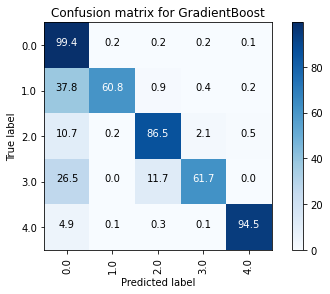

In [107]:
# check the metrics on testing dataset
mt.metrics_report(model_gb, 'GradientBoost', X_test, y_test, y_train, data='test')

__[top](#Contents)__  

### LightGBM

Fitting 5 folds for each of 972 candidates, totalling 4860 fits
[LightGBM] [Warning] seed is set=42, random_state=42 will be ignored. Current value: seed=42
Mean cross-validated score of the best_estimator: 0.9091
           Parameter Tuned value
0      boosting_type        gbdt
1       class_weight    balanced
2      learning_rate        0.05
3          max_depth          -1
4  min_child_samples          20
5       n_estimators         100
6         num_leaves          31
7          reg_alpha        0.07
8         reg_lambda           0
9          subsample           1
17511
70043
F1-score: 0.8264
Precision: 0.7695
Recall: 0.9142
Accuracy on train data: 0.9869
Accuracy on test data: 0.9529


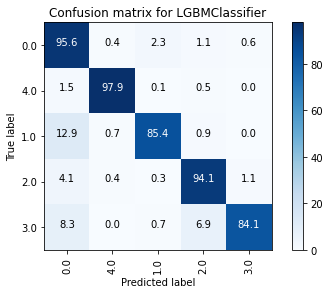

Wall time: 7h 12min 32s


In [24]:
%%time
import lightgbm as lgb

name='LGBMClassifier'
model = lgb.LGBMClassifier(random_state=42,
                         objective='multiclass', 
#                          n_jobs=51
                         )
 
steps=[]

parameters = {
    'LGBMClassifier__boosting_type': ['gbdt'],  # 'gbdt'
    'LGBMClassifier__num_leaves': [31],  # 31
    'LGBMClassifier__max_depth': [-1, 10, 50],  # -1
    'LGBMClassifier__learning_rate': [0.1, 0.05, 0.5],  # 0.1
    'LGBMClassifier__n_estimators': [100, 500],  # 100
#     'LGBMClassifier__subsample_for_bin': [200000],  # 200000
    'LGBMClassifier__class_weight': [None, 'balanced', {0:0.1, 1:0.3, 2:0.1, 3:0.4, 4:0.1}],  # None
#     'LGBMClassifier__min_split_gain': [0],  # 0
#     'LGBMClassifier__min_child_weight': [1e-3],  # 1e-3
    'LGBMClassifier__min_child_samples': [20],  # 20
    'LGBMClassifier__subsample': [1, 0.7],  # 1
#     'LGBMClassifier__colsample_bytree': [1],  # 1
    'LGBMClassifier__reg_alpha': [0, 0.03, 0.07],  # 0
    'LGBMClassifier__reg_lambda': [0, 0.03, 0.07],  # 0
}

model_lgbm, y_pred_lgbm = cls_models.checkmodel(
                                    name,
                                    model,
                                    steps=steps,
                                    parameters=parameters,
                                    average='macro',
                                    multiclass=True,
                                    metric='recall',
                                    randomized_search=False,
                                    nfolds=5,
                                    n_jobs=56,
                                    save_pickle=True,
                                    verbose=3
                                    )

              precision    recall  f1-score   support

         0.0       0.99      0.95      0.97     18118
         1.0       0.50      0.82      0.62       556
         2.0       0.86      0.95      0.90      1448
         3.0       0.46      0.85      0.59       162
         4.0       0.95      0.98      0.96      1608

    accuracy                           0.95     21892
   macro avg       0.75      0.91      0.81     21892
weighted avg       0.96      0.95      0.95     21892



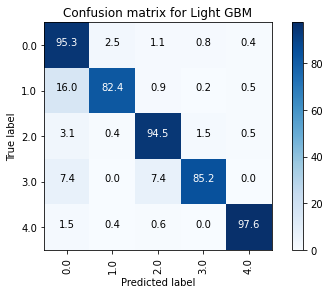

In [109]:
# check the metrics on testing dataset
mt.metrics_report(model_lgbm[0], 'Light GBM', X_test, y_test, y_train, data='test')

__[top](#Contents)__  

### AdaBoost

Fitting 5 folds for each of 9 candidates, totalling 45 fits
Mean cross-validated score of the best_estimator: 0.6226
        Parameter Tuned value
0  base_estimator        None
1   learning_rate           1
2    n_estimators         500
17511
70043
F1-score: 0.4422
Precision: 0.4277
Recall: 0.6269
Accuracy on train data: 0.6349
Accuracy on test data: 0.5853


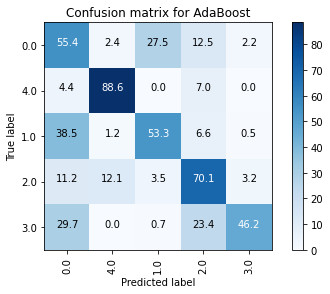

Wall time: 17min 52s


In [23]:
%%time
from sklearn.ensemble import AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.tree import DecisionTreeClassifier

name='AdaBoost'
model = AdaBoostClassifier(random_state=42)

steps=[]

parameters = {
    'AdaBoost__base_estimator': [None],  # None
    'AdaBoost__n_estimators': [50, 200, 500],  # 50
    'AdaBoost__learning_rate': [1, 0.05, 0.5],  # 1
#     'AdaBoost__algorithm': ['SAMME.R'],  # SAMME.R
}

model_ada, y_pred_ada = cls_models.checkmodel(
                                    name,
                                    model,
                                    steps=steps,
                                    parameters=parameters,
                                    average='macro',
                                    multiclass=True,
                                    metric='recall',
                                    randomized_search=False,
                                    nfolds=5,
                                    n_jobs=45,
                                    save_pickle=True,
                                    verbose=3
                                    )

              precision    recall  f1-score   support

         0.0       0.96      0.57      0.71     18118
         1.0       0.06      0.55      0.11       556
         2.0       0.31      0.74      0.44      1448
         3.0       0.12      0.40      0.19       162
         4.0       0.70      0.88      0.78      1608

    accuracy                           0.60     21892
   macro avg       0.43      0.63      0.44     21892
weighted avg       0.87      0.60      0.68     21892



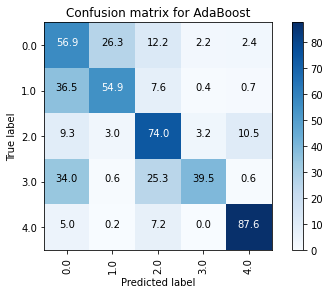

In [111]:
# check the metrics on testing dataset
mt.metrics_report(model_ada, 'AdaBoost', X_test, y_test, y_train, data='test')

__[top](#Contents)__  

### Random Forest

Fitting 5 folds for each of 48 candidates, totalling 240 fits
Mean cross-validated score of the best_estimator: 0.8682
                   Parameter Tuned value
0                  bootstrap        True
1               class_weight    balanced
2                  criterion        gini
3                  max_depth          10
4             max_leaf_nodes        None
5                max_samples        None
6      min_impurity_decrease           0
7           min_samples_leaf           5
8          min_samples_split           2
9   min_weight_fraction_leaf           0
10              n_estimators         100
11                 oob_score        True
F1-score: 0.7957
Precision: 0.7701
Recall: 0.881
Accuracy on train data: 0.9494
Accuracy on test data: 0.9509


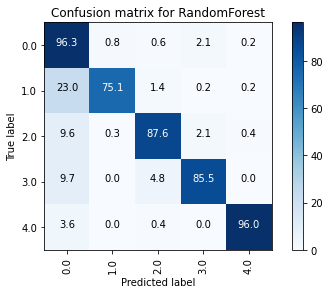

Wall time: 25min 4s


In [4]:
%%time
from sklearn.ensemble import RandomForestClassifier

name='RandomForest'
model = RandomForestClassifier(random_state=42,
                              n_jobs=None,  # None
                              )

steps=[]

parameters = {
    'RandomForest__n_estimators': [100, 500],  # 100
    'RandomForest__criterion': ['gini'],  # gini
    'RandomForest__max_depth': [None, 5, 10],  # None
    'RandomForest__min_samples_split': [2, 5],  # 2
    'RandomForest__min_samples_leaf': [1, 5],  # 1
    'RandomForest__min_weight_fraction_leaf': [0],  # 0
#     'RandomForest__max_features': ['auto'],  # auto
    'RandomForest__max_leaf_nodes': [None],  # None
    'RandomForest__min_impurity_decrease': [0],  # 0
    'RandomForest__bootstrap': [True],  # True
    'RandomForest__oob_score': [True],  # False - only if bootstrap=True
    'RandomForest__max_samples': [None],  # None - if bootstrap=True
    'RandomForest__class_weight': [None, 'balanced'],  # None
}

model_rf, y_pred_rf = cls_models.checkmodel(
                                    name,
                                    model,
                                    steps=steps,
                                    parameters=parameters,
                                    average='macro',
                                    multiclass=True,
                                    metric='recall',
                                    randomized_search=False,
                                    nfolds=5,
                                    n_jobs=56,
                                    save_pickle=True,
                                    verbose=3
                                    )

              precision    recall  f1-score   support

         0.0       0.98      0.96      0.97     18118
         1.0       0.69      0.71      0.70       556
         2.0       0.92      0.89      0.90      1448
         3.0       0.25      0.83      0.39       162
         4.0       0.97      0.94      0.96      1608

    accuracy                           0.95     21892
   macro avg       0.76      0.87      0.78     21892
weighted avg       0.96      0.95      0.95     21892



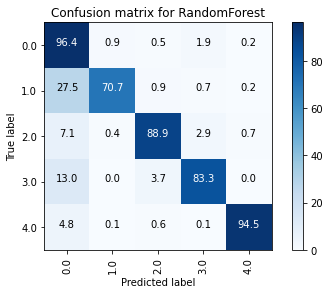

In [5]:
# check the metrics on testing dataset
mt.metrics_report(model_rf, 'RandomForest', X_test, y_test, y_train, data='test')

__[top](#Contents)__  

## Deep Learning

In [16]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Reshape, Dense, Activation, Flatten, Convolution1D, Dropout
from tensorflow.keras.layers import Dense, Flatten, Dropout, LSTM, Input, MaxPooling1D, GlobalAveragePooling1D
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, BatchNormalization, Bidirectional

from tensorflow.keras import optimizers

from tensorflow.keras.wrappers.scikit_learn import KerasClassifier

from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping, History, ModelCheckpoint, LambdaCallback

from sklearn.model_selection import cross_val_score, KFold
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import Pipeline
# from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from tensorflow.keras.models import load_model

# from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

X_train = np.array(X_train)
X_val = np.array(X_val)
X_test = np.array(X_test)

y_train_dummy=to_categorical(y_train)
y_val_dummy=to_categorical(y_val)
y_test_dummy=to_categorical(y_test)
y_train_dummy.shape

(70043, 5)

In [5]:
# For conv1D dimentionality should be 187X1 where 187 is number of features and 1 = 1D Dimentionality of data
X_train = X_train.reshape(len(X_train), X_train.shape[1], 1)
X_val = X_val.reshape(len(X_val), X_val.shape[1], 1)
X_test = X_test.reshape(len(X_test), X_test.shape[1], 1)


__[top](#Contents)__  

## CNN

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_3 (Conv1D)            (None, 187, 64)           448       
_________________________________________________________________
batch_normalization_3 (Batch (None, 187, 64)           256       
_________________________________________________________________
max_pooling1d_3 (MaxPooling1 (None, 94, 64)            0         
_________________________________________________________________
conv1d_4 (Conv1D)            (None, 94, 64)            24640     
_________________________________________________________________
batch_normalization_4 (Batch (None, 94, 64)            256       
_________________________________________________________________
max_pooling1d_4 (MaxPooling1 (None, 47, 64)            0         
_________________________________________________________________
conv1d_5 (Conv1D)            (None, 47, 64)           

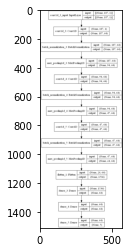

In [24]:
def create_model(kernel_size=6, padding='same', strides=2, pool_size=2, lr=0.001, cl=2, cf=64, dl=2, dn=64, dense=True):
    """
    cl - CNN layers
    cf - CNN filters
    dl - DNN layers
    dn - DNN neurons
    """
    model = Sequential()

    model.add(Conv1D(filters=cf, kernel_size=kernel_size, activation='relu', padding=padding,
                     input_shape=(X_train.shape[1], 1)))
    model.add(BatchNormalization())  # Normalization to avoid overfitting
    model.add(MaxPooling1D(pool_size=pool_size, strides=strides, padding=padding))

    # Add as many hidden layers as specified in nl
    for i in range(cl):
        # Layers have nn filters
        model.add(Conv1D(filters=cf, kernel_size=kernel_size, activation='relu', padding=padding))
        model.add(BatchNormalization())
        model.add(MaxPooling1D(pool_size=pool_size, strides=strides, padding=padding))

    model.add(Flatten())

    if dense:
        for i in range(dl):
            model.add(Dense(units=dn, activation='relu'))

    # Output Layer
    model.add(Dense(5, activation='softmax'))  # output layer

    # loss = 'categorical_crossentropy'
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=lr),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    return model

model = create_model(
    kernel_size=6, 
    padding='same', 
    strides=2, 
    pool_size=2, 
    lr=0.001, 
    cl=2, 
    cf=64, 
    dl=2, 
    dn=64, 
    dense=True,
)

print(model.summary())

from tensorflow.keras.utils import plot_model
from matplotlib import pyplot as plt
plot_model(model, to_file ='CNN.png', show_shapes=True)
img = plt.imread('CNN.png')
plt.imshow(img)
plt.show()



In [1]:
%%time

name = 'CNN'

early_stopping_monitor = EarlyStopping(monitor='val_loss', patience=5)

mc = ModelCheckpoint(f"./temp_pickle_models/{name}_check.h5", monitor='val_loss', save_best_only=True)

from keras.callbacks import CSVLogger
csv_logger = CSVLogger(f"{name}.csv", append=True, separator=';')

hist = model.fit(X_train, y_train_dummy,
                    batch_size=32,
                    epochs=100,
                    validation_data=(X_val, y_val_dummy),
                    callbacks=[early_stopping_monitor, mc, csv_logger])


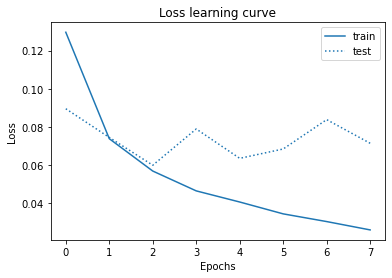

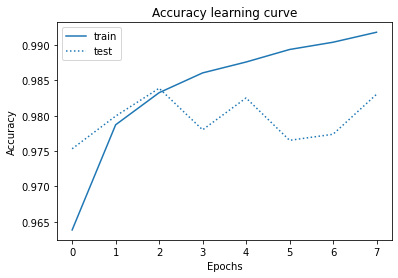

In [34]:
reload(mt)
mt.learning_cuve(hist.history['loss'], hist.history['val_loss'], name='Loss') 
mt.learning_cuve(hist.history['accuracy'], hist.history['val_accuracy'], name='Accuracy')   

C:\Users\nastiag67\Anaconda3\lib\site-packages\tensorflow\python\keras\engine\sequential.py:430: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


              precision    recall  f1-score   support

           0       0.99      1.00      0.99     14579
           1       0.93      0.73      0.82       426
           2       0.95      0.94      0.95      1112
           3       0.88      0.74      0.81       145
           4       0.98      0.99      0.99      1249

    accuracy                           0.98     17511
   macro avg       0.94      0.88      0.91     17511
weighted avg       0.98      0.98      0.98     17511



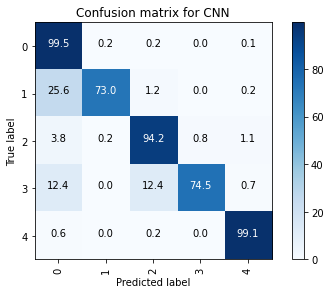

ROC-AUC score: 0.9946


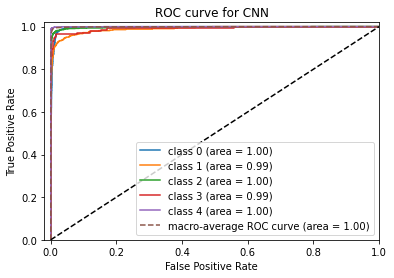

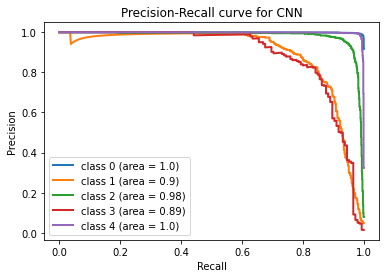

In [36]:
y_pred = model.predict(X_test)

name = 'CNN'

roc = mt.ROCcurve_multiclass
pr = mt.PR_multiclass
cm = mt.CM

mt.compare_models(model, name, X_test, y_test_dummy, y_train_dummy, cm, roc, pr, proba=True, data='test')

__[top](#Contents)__  

## LSTM

In [ ]:
name = 'LSTM'

tf.random.set_seed(42)

def create_model(lr=0.001, layers=1, units=64, dense_layers=2, dense_neurons=64):
    model = Sequential()

    # Input Layer
    model.add(LSTM(X_train.shape[1], input_shape=X_train.shape[1:],  return_sequences=True))

    # LSTM Layers
    for i in range(layers):
        model.add(LSTM(units, return_sequences=True))
        model.add(Dropout(0.2))

    model.add(Flatten())

    # Dense Layers
    for i in range(dense_layers):
        model.add(Dense(units=dense_neurons, activation='relu'))

    # Output layer
    model.add(Dense(5, activation='softmax'))

    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=lr),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    return model

model = KerasClassifier(build_fn=create_model, verbose=0)

params = {
    'lr': [0.001],  # 0.001
    'layers': [2, 5],  # 5
    'units': [64, 128],  # 128
    'dense_layers': [0, 2],  # 0roc_auc_score
    'dense_neurons': [64, 128],  # 128
}

# total fits: 48
cv = RandomizedSearchCV(
    estimator=model,
    param_distributions=params,
    cv=3,
    random_state=42,
    verbose=3,
    n_iter=25,
)

early_stopping_monitor = EarlyStopping(monitor='val_loss', patience=3)

history = History()

mc = ModelCheckpoint(f"./temp_pickle_models/{name}.h5", monitor='val_loss', save_best_only=True)

csv_logger = CSVLogger(f"log_history_{name}.csv", append=True, separator=';')

cv_results = cv.fit(X_train, y_train_dummy,
                    batch_size=32,
                    epochs=15,
                    validation_data=(X_val, y_val_dummy),
                    callbacks=[early_stopping_monitor, mc, history, csv_logger])

print(cv.best_params_)


In [ ]:
y_pred = model.predict(X_val)

roc = mt.ROCcurve_multiclass
pr = mt.PR_multiclass
cm = mt.CM

mt.compare_models(model, name, X_val, y_val_dummy, y_train_dummy, cm, roc, pr, proba=True, data='validation')

In [ ]:
mt.compare_models(model, name, X_test, y_test_dummy, y_train_dummy, cm, roc, pr, proba=True, data='test')

__[top](#Contents)__  

## Bidirectional LSTM

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional (Bidirectional (None, 187, 128)          33792     
_________________________________________________________________
bidirectional_1 (Bidirection (None, 187, 128)          98816     
_________________________________________________________________
dropout (Dropout)            (None, 187, 128)          0         
_________________________________________________________________
bidirectional_2 (Bidirection (None, 187, 128)          98816     
_________________________________________________________________
dropout_1 (Dropout)          (None, 187, 128)          0         
_________________________________________________________________
bidirectional_3 (Bidirection (None, 187, 128)          98816     
_________________________________________________________________
dropout_2 (Dropout)          (None, 187, 128)         

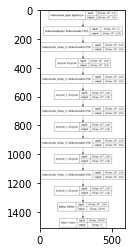

In [17]:
name = 'BLSTM'

X_train = np.array(X_train)
X_val = np.array(X_val)
X_test = np.array(X_test)

y_train_dummy=to_categorical(y_train)
y_val_dummy=to_categorical(y_val)
y_test_dummy=to_categorical(y_test)
y_train_dummy.shape

X_train = X_train.reshape(len(X_train), X_train.shape[1], 1)
X_val = X_val.reshape(len(X_val), X_val.shape[1], 1)
X_test = X_test.reshape(len(X_test), X_test.shape[1], 1)

tf.random.set_seed(42)


def create_model(lr=0.001, layers=1, units=64, dense_layers=2, dense_neurons=64):
    model = Sequential()

    # Input Layer
    model.add(Bidirectional(LSTM(units, return_sequences=True), input_shape=X_train.shape[1:]))

    # LSTM Layers
    for i in range(layers):
        model.add(Bidirectional(LSTM(units, return_sequences=True)))
        model.add(Dropout(0.2))

    model.add(Flatten())

    # Dense Layers
    for i in range(dense_layers):
        model.add(Dense(units=dense_neurons, activation='relu'))

    # Output layer
    model.add(Dense(5, activation='softmax'))

    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=lr),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    return model


model = KerasClassifier(build_fn=create_model, verbose=0)

params = {
    'lr': [0.001],
    'layers': [2,5],
    'units': [64, 128],
    'dense_layers': [0, 2],
    'dense_neurons': [64, 128],
}

cv = RandomizedSearchCV(
    estimator=model,
    param_distributions=params,
    cv=3,
    random_state=42,
    verbose=3,
    n_iter=25,
)

early_stopping_monitor = EarlyStopping(monitor='val_loss', patience=3)

history = History()

mc = ModelCheckpoint(f"./temp_pickle_models/{name}.h5", monitor='val_loss', save_best_only=True)

csv_logger = CSVLogger(f"log_history_{name}.csv", append=True, separator=';')

# sys.stdout = open('log_CV.csv', 'w')
cv_results = cv.fit(X_train, y_train_dummy,
                    batch_size=32,
                    epochs=15,
                    validation_data=(X_val, y_val_dummy),
                    callbacks=[early_stopping_monitor, mc, history, csv_logger])

print(cv.best_params_)


In [ ]:
y_pred = model.predict(X_val)

roc = mt.ROCcurve_multiclass
pr = mt.PR_multiclass
cm = mt.CM

mt.compare_models(model, name, X_val, y_val_dummy, y_train_dummy, cm, roc, pr, proba=True, data='validation')

In [ ]:
mt.compare_models(model, name, X_test, y_test_dummy, y_train_dummy, cm, roc, pr, proba=True, data='test')

__[top](#Contents)__  

# Resamling  



## SMOTE-Tomek Links Method


### SMOTE-Tomek Links for SVM

Fitting 5 folds for each of 15 candidates, totalling 75 fits
Mean cross-validated score of the best_estimator: 0.9108
      Parameter Tuned value
0             C           1
1  class_weight    balanced
2         gamma         0.1
F1-score: 0.7758
Precision: 0.7182
Recall: 0.9227
Accuracy on train data: 0.9651
Accuracy on test data: 0.94


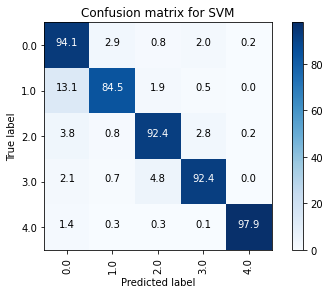

Wall time: 8h 21min 48s


In [13]:
%%time

name = 'SVM'
model = SVC()

resample=SMOTETomek(tomek=TomekLinks(sampling_strategy='majority'), random_state=42)

steps=[
    ('r', resample),
]

parameters = {
    'SVM__C': [1, 10, 50],
    # Regularization - tells the SVM optimization how much error is bearable
    # control the trade-off between decision boundary and misclassification term
    # smaller value => small-margin hyperplane
    # 'SVM__kernel': ['linear', 'poly', 'rbf', 'sigmoid'],  # VERY long pls don't
    # 'SVM__degree': [3],
    'SVM__gamma': [0.1, 0.5, 0.07, 'scale', 'auto'],  # scale
    'SVM__class_weight': ['balanced'],  # None
    }

model_svm, y_pred_svm = cls_models.checkmodel(
                                    name,
                                    model,
                                    steps=steps,
                                    parameters=parameters,
                                    average='macro',
                                    multiclass=True,
                                    metric='recall',
                                    randomized_search=False,
                                    nfolds=5,
                                    n_jobs=56,
                                    save_pickle=True,
                                    verbose=3
                                    )


              precision    recall  f1-score   support

         0.0       0.99      0.94      0.96     18118
         1.0       0.42      0.82      0.56       556
         2.0       0.89      0.93      0.91      1448
         3.0       0.29      0.90      0.44       162
         4.0       0.97      0.98      0.98      1608

    accuracy                           0.94     21892
   macro avg       0.71      0.91      0.77     21892
weighted avg       0.96      0.94      0.95     21892



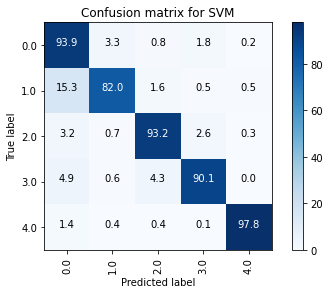

In [7]:
# check the metrics on testing dataset
mt.metrics_report(model_svm, 'SVM', X_test, y_test, y_train, data='test')

__[top](#Contents)__  

### SMOTE-Tomek Links for LightGBM

Fitting 5 folds for each of 972 candidates, totalling 4860 fits
[LightGBM] [Warning] seed is set=42, random_state=42 will be ignored. Current value: seed=42
Mean cross-validated score of the best_estimator: 0.9156
           Parameter Tuned value
0      boosting_type        gbdt
1       class_weight         0.1
2      learning_rate         0.1
3          max_depth          10
4  min_child_samples          20
5       n_estimators         100
6         num_leaves          31
7          reg_alpha        0.03
8         reg_lambda        0.07
9          subsample           1
F1-score: 0.7993
Precision: 0.7407
Recall: 0.9154
Accuracy on train data: 0.9833
Accuracy on test data: 0.9445


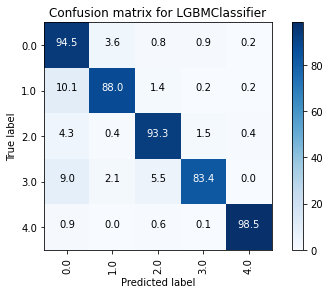

Wall time: 14d 15h 45min 32s


In [6]:
%%time
import lightgbm as lgb

name='LGBMClassifier'
model = lgb.LGBMClassifier(random_state=42,
                         objective='multiclass', 
#                          n_jobs=51
                         )
 
resample=SMOTETomek(tomek=TomekLinks(sampling_strategy='majority'), random_state=42)

steps=[
    ('r', resample),
]

parameters = {
    'LGBMClassifier__boosting_type': ['gbdt'],  # 'gbdt'
    'LGBMClassifier__num_leaves': [31],  # 31
    'LGBMClassifier__max_depth': [-1, 10, 50],  # -1
    'LGBMClassifier__learning_rate': [0.1, 0.05, 0.5],  # 0.1
    'LGBMClassifier__n_estimators': [100, 500],  # 100
#     'LGBMClassifier__subsample_for_bin': [200000],  # 200000
    'LGBMClassifier__class_weight': [None, 'balanced', {0:0.1, 1:0.3, 2:0.1, 3:0.4, 4:0.1}],  # None
#     'LGBMClassifier__min_split_gain': [0],  # 0
#     'LGBMClassifier__min_child_weight': [1e-3],  # 1e-3
    'LGBMClassifier__min_child_samples': [20],  # 20
    'LGBMClassifier__subsample': [1, 0.7],  # 1
#     'LGBMClassifier__colsample_bytree': [1],  # 1
    'LGBMClassifier__reg_alpha': [0, 0.03, 0.07],  # 0
    'LGBMClassifier__reg_lambda': [0, 0.03, 0.07],  # 0
}

model_lgbm, y_pred_lgbm = cls_models.checkmodel(
                                    name,
                                    model,
                                    steps=steps,
                                    parameters=parameters,
                                    average='macro',
                                    multiclass=True,
                                    metric='recall',
                                    randomized_search=False,
                                    nfolds=5,
                                    n_jobs=56,
                                    save_pickle=True,
                                    verbose=3
                                    )

Correct hyperparameters:

                   Parameter Tuned value
        0      boosting_type        gbdt
        1       class_weight         balanced
        2      learning_rate         0.05
        3          max_depth          10
        4  min_child_samples          20
        5       n_estimators         100
        6         num_leaves          31
        7          reg_alpha        0.07
        8         reg_lambda        0.03
        9          subsample         0.7


              precision    recall  f1-score   support

         0.0       0.99      0.97      0.98     14579
         1.0       0.60      0.82      0.69       426
         2.0       0.89      0.94      0.92      1112
         3.0       0.60      0.81      0.69       145
         4.0       0.98      0.98      0.98      1249

    accuracy                           0.97     17511
   macro avg       0.81      0.91      0.85     17511
weighted avg       0.97      0.97      0.97     17511



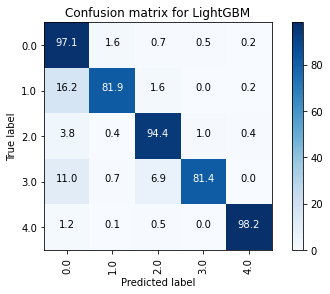

In [91]:
# check the metrics on validation dataset
mt.metrics_report(loaded_model, 'LightGBM', X_val, y_val, y_train, data='validation')

              precision    recall  f1-score   support

         0.0       0.99      0.97      0.98     18118
         1.0       0.58      0.79      0.67       556
         2.0       0.91      0.94      0.92      1448
         3.0       0.53      0.84      0.65       162
         4.0       0.98      0.98      0.98      1608

    accuracy                           0.96     21892
   macro avg       0.80      0.90      0.84     21892
weighted avg       0.97      0.96      0.97     21892



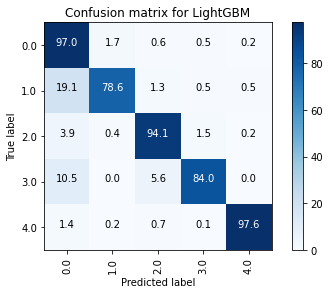

In [12]:
# check the metrics on testing dataset
mt.metrics_report(model_lgbm, 'LightGBM', X_test, y_test, y_train, data='test')

__[top](#Contents)__  

### SMOTE-Tomek Links for Random Forest

Fitting 5 folds for each of 48 candidates, totalling 240 fits
Mean cross-validated score of the best_estimator: 0.8936
                   Parameter Tuned value
0                  bootstrap        True
1               class_weight        None
2                  criterion        gini
3                  max_depth          10
4             max_leaf_nodes        None
5                max_samples        None
6      min_impurity_decrease           0
7           min_samples_leaf           1
8          min_samples_split           2
9   min_weight_fraction_leaf           0
10              n_estimators         500
11                 oob_score        True 

              precision    recall  f1-score   support

         0.0       0.99      0.96      0.97     14579
         1.0       0.62      0.81      0.71       426
         2.0       0.90      0.89      0.90      1112
         3.0       0.27      0.86      0.41       145
         4.0       0.96      0.96      0.96      1249

    accuracy        

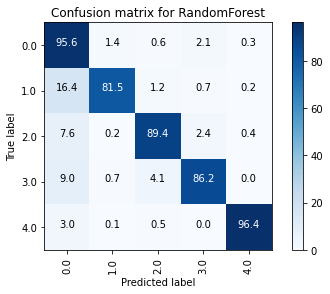

In [6]:
%%time
from sklearn.ensemble import RandomForestClassifier

name='RandomForest'
model = RandomForestClassifier(random_state=42,
#                               n_jobs=None,  # None
                              )

resample=SMOTETomek(tomek=TomekLinks(sampling_strategy='majority'), random_state=42)

steps=[
    ('r', resample),
]

parameters = {
    'RandomForest__n_estimators': [100, 500],  # 100
    'RandomForest__criterion': ['gini'],  # gini
    'RandomForest__max_depth': [None, 5, 10],  # None
    'RandomForest__min_samples_split': [2, 5],  # 2
    'RandomForest__min_samples_leaf': [1, 5],  # 1
    'RandomForest__min_weight_fraction_leaf': [0],  # 0
#     'RandomForest__max_features': ['auto'],  # auto
    'RandomForest__max_leaf_nodes': [None],  # None
    'RandomForest__min_impurity_decrease': [0],  # 0
    'RandomForest__bootstrap': [True],  # True
    'RandomForest__oob_score': [True],  # False - only if bootstrap=True
    'RandomForest__max_samples': [None],  # None - if bootstrap=True
    'RandomForest__class_weight': [None, 'balanced'],  # None
}

model_rf, y_pred_rf = cls_models.checkmodel(
                                    name,
                                    model,
                                    steps=steps,
                                    parameters=parameters,
                                    average='macro',
                                    multiclass=True,
                                    metric='recall',
                                    randomized_search=False,
                                    nfolds=5,
                                    n_jobs=56,
                                    save_pickle=True,
                                    verbose=3
                                    )

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Mean cross-validated score of the best_estimator: 0.8936
                   Parameter Tuned value
0                  bootstrap        True
1               class_weight        None
2                  criterion        gini
3                  max_depth          10
4             max_leaf_nodes        None
5                max_samples        None
6      min_impurity_decrease           0
7           min_samples_leaf           1
8          min_samples_split           2
9   min_weight_fraction_leaf           0
10              n_estimators         500
11                 oob_score        True 

              precision    recall  f1-score   support

         0.0       0.99      0.96      0.97     14579
         1.0       0.62      0.81      0.71       426
         2.0       0.90      0.89      0.90      1112
         3.0       0.27      0.86      0.41       145
         4.0       0.96      0.96      0.96      1249

    accuracy           

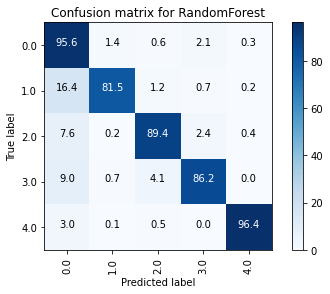

In [4]:
%%time
from sklearn.ensemble import RandomForestClassifier

name='RandomForest'
model = RandomForestClassifier(random_state=42,
#                               n_jobs=None,  # None
                              )

resample=SMOTETomek(tomek=TomekLinks(sampling_strategy='majority'), random_state=42)

steps=[
    ('r', resample),
]

parameters = {
    'RandomForest__n_estimators': [500],  # 100
    'RandomForest__criterion': ['gini'],  # gini
    'RandomForest__max_depth': [10],  # None
    'RandomForest__min_samples_split': [2],  # 2
    'RandomForest__min_samples_leaf': [1],  # 1
    'RandomForest__min_weight_fraction_leaf': [0],  # 0
#     'RandomForest__max_features': ['auto'],  # auto
    'RandomForest__max_leaf_nodes': [None],  # None
    'RandomForest__min_impurity_decrease': [0],  # 0
    'RandomForest__bootstrap': [True],  # True
    'RandomForest__oob_score': [True],  # False - only if bootstrap=True
    'RandomForest__max_samples': [None],  # None - if bootstrap=True
    'RandomForest__class_weight': [None],  # None
}

model_rf, y_pred_rf = cls_models.checkmodel(
                                    name,
                                    model,
                                    steps=steps,
                                    parameters=parameters,
                                    average='macro',
                                    multiclass=True,
                                    metric='recall',
                                    randomized_search=False,
                                    nfolds=5,
                                    n_jobs=5,
                                    save_pickle=True,
                                    verbose=3
                                    )

              precision    recall  f1-score   support

         0.0       0.98      0.95      0.97     18118
         1.0       0.60      0.76      0.67       556
         2.0       0.92      0.90      0.91      1448
         3.0       0.22      0.87      0.35       162
         4.0       0.96      0.95      0.96      1608

    accuracy                           0.94     21892
   macro avg       0.74      0.89      0.77     21892
weighted avg       0.96      0.94      0.95     21892



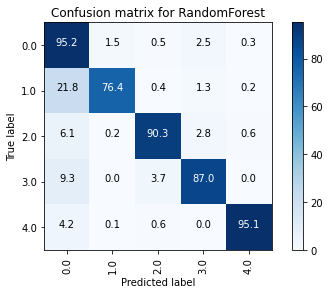

In [5]:
# check the metrics on testing dataset
mt.metrics_report(model_rf, 'RandomForest', X_test, y_test, y_train, data='test')

__[top](#Contents)__  

### SMOTE-Tomek Links for CNN

In [ ]:
name = 'CNN'

from imblearn.combine import SMOTEENN, SMOTETomek
from imblearn.under_sampling import EditedNearestNeighbours, TomekLinks
resample = SMOTETomek(tomek=TomekLinks(sampling_strategy='majority'), random_state=42)
X_train, y_train = resample.fit_resample(X_train, y_train)

X_train = np.array(X_train)
X_val = np.array(X_val)
X_test = np.array(X_test)

y_train_dummy=to_categorical(y_train)
y_val_dummy=to_categorical(y_val)
y_test_dummy=to_categorical(y_test)

X_train = X_train.reshape(len(X_train), X_train.shape[1], 1)
X_val = X_val.reshape(len(X_val), X_val.shape[1], 1)
X_test = X_test.reshape(len(X_test), X_test.shape[1], 1)

tf.random.set_seed(42)

def create_model(kernel_size=6, padding='same', strides=2, pool_size=2, lr=0.001, cl=2, cf=64, dl=2, dn=64):
    """
    cl - CNN layers
    cf - CNN filters
    dl - DNN layers
    dn - DNN neurons
    """
    model = Sequential()

    # Input Layer
    model.add(Conv1D(filters=cf, kernel_size=kernel_size, activation='relu', padding=padding, input_shape=(X_train.shape[1], 1)))
    model.add(BatchNormalization()) 
    model.add(MaxPooling1D(pool_size=pool_size, strides=strides, padding=padding))

    # CNN Layers
    for i in range(cl):
        model.add(Conv1D(filters=cf, kernel_size=kernel_size, activation='relu', padding=padding))
        model.add(BatchNormalization())
        model.add(MaxPooling1D(pool_size=pool_size, strides=strides, padding=padding))

    model.add(Flatten())

    # Dense Layers
    for i in range(dl):
        model.add(Dense(units=dn, activation='relu'))

    # Output Layer
    model.add(Dense(5, activation='softmax'))  # output layer

    # loss = 'categorical_crossentropy'
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=lr),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    return model


model = KerasClassifier(build_fn=create_model, verbose=0)

params = {
    'kernel_size': [3, 6],  # 6
    'padding': ['same'],
    'strides': [1, 2],  # 2
    'pool_size': [2, 5],  # 2
    'cl': [2, 3],  # 2
    'cf': [64, 128],  # 64
    'dl': [1, 2],  # 2
    'dn': [64, 128],  # 64
}

# total fits: 75
cv = RandomizedSearchCV(
    estimator=model,
    param_distributions=params,
    cv=3,
    random_state=42,
    verbose=3,
    n_iter=25,
)

early_stopping_monitor = EarlyStopping(monitor='val_loss', patience=3)

history = History()

mc = ModelCheckpoint(f"./temp_pickle_models/{name}.h5", monitor='val_loss', save_best_only=True)

csv_logger = CSVLogger(f"log_history_{name}.csv", append=True, separator=';')

cv_results = cv.fit(X_train, y_train_dummy,
                    batch_size=32,
                    epochs=15,
                    validation_data=(X_val, y_val_dummy),
                    callbacks=[early_stopping_monitor, mc, history, csv_logger])

print(cv.best_params_)


__[top](#Contents)__  

### SMOTE-Tomek Links for LSTM

In [ ]:
name = 'LSTM'

from imblearn.combine import SMOTEENN, SMOTETomek
from imblearn.under_sampling import EditedNearestNeighbours, TomekLinks
resample = SMOTETomek(tomek=TomekLinks(sampling_strategy='majority'), random_state=42)
X_train, y_train = resample.fit_resample(X_train, y_train)

X_train = np.array(X_train)
X_val = np.array(X_val)
X_test = np.array(X_test)

y_train_dummy=to_categorical(y_train)
y_val_dummy=to_categorical(y_val)
y_test_dummy=to_categorical(y_test)

X_train = X_train.reshape(len(X_train), X_train.shape[1], 1)
X_val = X_val.reshape(len(X_val), X_val.shape[1], 1)
X_test = X_test.reshape(len(X_test), X_test.shape[1], 1)

tf.random.set_seed(42)

def create_model(lr=0.001, layers=1, units=64, dense_layers=2, dense_neurons=64):
    """
    ll - LSTM layers
    lu - LSTM units
    dl - DNN layers
    dn - DNN neurons
    """
    model = Sequential()

    # Input Layer
    model.add(LSTM(X_train.shape[1], input_shape=X_train.shape[1:], return_sequences=True))

    # LSTM Layers
    for i in range(layers):
        model.add(LSTM(units, return_sequences=True))
        model.add(Dropout(0.2))

    model.add(Flatten())

    # Dense Layers
    for i in range(dense_layers):
        model.add(Dense(units=dense_neurons, activation='relu'))

    # Output layer
    model.add(Dense(5, activation='softmax'))

    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=lr),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    return model

model = KerasClassifier(build_fn=create_model, verbose=0)

params = {
    'lr': [0.001],  # 0.001
    'layers': [2, 5],  # 5
    'units': [64, 128],  # 128
    'dense_layers': [0, 2],  # 0
    'dense_neurons': [64, 128],  # 128
}

# total fits: 75
cv = RandomizedSearchCV(
    estimator=model,
    param_distributions=params,
    cv=3,
    random_state=42,
    verbose=3,
    n_iter=25,
)

early_stopping_monitor = EarlyStopping(monitor='val_loss', patience=3)

history = History()

mc = ModelCheckpoint(f"./temp_pickle_models/{name}.h5", monitor='val_loss', save_best_only=True)

csv_logger = CSVLogger(f"log_history_{name}.csv", append=True, separator=';')

cv_results = cv.fit(X_train, y_train_dummy,
                    batch_size=32,
                    epochs=15,
                    validation_data=(X_val, y_val_dummy),
                    callbacks=[early_stopping_monitor, mc, history, csv_logger])
print(cv.best_params_)


__[top](#Contents)__  

### SMOTE-Tomek Links for BLSTM

In [ ]:
from imblearn.combine import SMOTEENN, SMOTETomek
from imblearn.under_sampling import EditedNearestNeighbours, TomekLinks
resample = SMOTETomek(tomek=TomekLinks(sampling_strategy='majority'), random_state=42)
X_train, y_train = resample.fit_resample(X_train, y_train)

X_train = np.array(X_train)
X_val = np.array(X_val)
X_test = np.array(X_test)

y_train_dummy=to_categorical(y_train)
y_val_dummy=to_categorical(y_val)
y_test_dummy=to_categorical(y_test)

X_train = X_train.reshape(len(X_train), X_train.shape[1], 1)
X_val = X_val.reshape(len(X_val), X_val.shape[1], 1)
X_test = X_test.reshape(len(X_test), X_test.shape[1], 1)

tf.random.set_seed(42)

name='BLSTM'

def create_model(lr=0.001, layers=1, units=64, dense_layers=2, dense_neurons=64):
    model = Sequential()

    # Input Layer
    model.add(Bidirectional(LSTM(units, return_sequences=True), input_shape=X_train.shape[1:]))

    # LSTM Layers
    for i in range(layers):
        model.add(Bidirectional(LSTM(units, return_sequences=True)))
        model.add(Dropout(0.2))

    model.add(Flatten())

    # Dense Layers
    for i in range(dense_layers):
        model.add(Dense(units=dense_neurons, activation='relu'))

    # Output layer
    model.add(Dense(5, activation='softmax'))

    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=lr),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    return model


model = KerasClassifier(build_fn=create_model, verbose=0)

params = {
    'lr': [0.001],  #
    'layers': [2, 5],  #
    'units': [64, 128],  #
    'dense_layers': [0, 2],  #
    'dense_neurons': [64, 128],  #
}

# total fits:
cv = RandomizedSearchCV(
     estimator=model,
     param_distributions=params,
     cv=3,
     random_state=42,
     verbose=3,
     n_iter=25,
 )


early_stopping_monitor = EarlyStopping(monitor='val_loss', patience=3)

history = History()

mc = ModelCheckpoint(f"./temp_pickle_models/{name}.h5", monitor='val_loss', save_best_only=True)

csv_logger = CSVLogger(f"log_history_{name}.csv", append=True, separator=';')

cv_results = cv.fit(X_train, y_train_dummy,
                    batch_size=32,
                    epochs=15,
                    validation_data=(X_val, y_val_dummy),
                    callbacks=[early_stopping_monitor, mc, history, csv_logger])
print(cv.best_params_)


__[top](#Contents)__ 
    
## SMOTE-ENN Method



In [5]:
# resample=SMOTETomek(tomek=TomekLinks(sampling_strategy='majority'), random_state=42)
resample=SMOTEENN(enn=EditedNearestNeighbours(sampling_strategy='all'), random_state=42)
X, y = resample.fit_resample(X_train, y_train)
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 286428 entries, 0 to 286427
Columns: 187 entries, 0 to 186
dtypes: float64(187)
memory usage: 408.6 MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 286428 entries, 0 to 286427
Columns: 187 entries, 0 to 186
dtypes: float64(187)
memory usage: 408.6 MB


__[top](#Contents)__  

### SMOTE-ENN for SVM

Fitting 5 folds for each of 15 candidates, totalling 75 fits
Fitting 5 folds for each of 15 candidates, totalling 75 fits
Mean cross-validated score of the best_estimator: 0.9118
      Parameter Tuned value
0             C           1
1  class_weight    balanced
2         gamma         0.1 

Mean cross-validated score of the best_estimator: 0.9118
      Parameter Tuned value
0             C           1
1  class_weight    balanced
2         gamma         0.1 

              precision    recall  f1-score   support

         0.0       0.99      0.93      0.96     14579
         1.0       0.43      0.87      0.57       426
         2.0       0.86      0.93      0.89      1112
         3.0       0.29      0.92      0.44       145
         4.0       0.97      0.98      0.97      1249

    accuracy                           0.94     17511
   macro avg       0.71      0.93      0.77     17511
weighted avg       0.96      0.94      0.94     17511

              precision    recall  f1-score   s

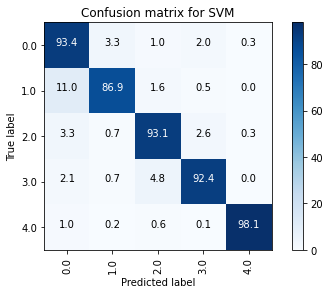

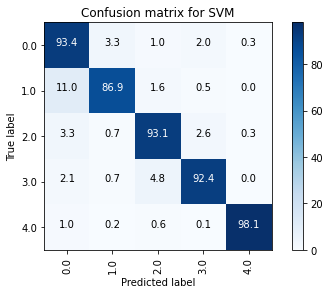

In [6]:
%%time

name = 'SVM'
model = SVC()

resample=SMOTEENN(enn=EditedNearestNeighbours(sampling_strategy='all'), random_state=42)

steps=[
    ('r', resample),
]

parameters = {
    'SVM__C': [1, 10, 50],
    # Regularization - tells the SVM optimization how much error is bearable
    # control the trade-off between decision boundary and misclassification term
    # smaller value => small-margin hyperplane
    # 'SVM__kernel': ['linear', 'poly', 'rbf', 'sigmoid'],  # VERY long pls don't
    # 'SVM__degree': [3],
    'SVM__gamma': [0.1, 0.5, 0.07, 'scale', 'auto'],  # scale
    'SVM__class_weight': ['balanced'],  # None
    }

model_svm, y_pred_svm = cls_models.checkmodel(
                                    name,
                                    model,
                                    steps=steps,
                                    parameters=parameters,
                                    average='macro',
                                    multiclass=True,
                                    metric='recall',
                                    randomized_search=False,
                                    nfolds=5,
                                    n_jobs=56,
                                    verbose=3
                                    )


              precision    recall  f1-score   support

         0.0       0.99      0.93      0.96     18118
         1.0       0.40      0.83      0.54       556
         2.0       0.87      0.94      0.90      1448
         3.0       0.28      0.90      0.43       162
         4.0       0.97      0.98      0.97      1608

    accuracy                           0.93     21892
   macro avg       0.70      0.91      0.76     21892
weighted avg       0.96      0.93      0.94     21892

              precision    recall  f1-score   support

         0.0       0.99      0.93      0.96     18118
         1.0       0.40      0.83      0.54       556
         2.0       0.87      0.94      0.90      1448
         3.0       0.28      0.90      0.43       162
         4.0       0.97      0.98      0.97      1608

    accuracy                           0.93     21892
   macro avg       0.70      0.91      0.76     21892
weighted avg       0.96      0.93      0.94     21892



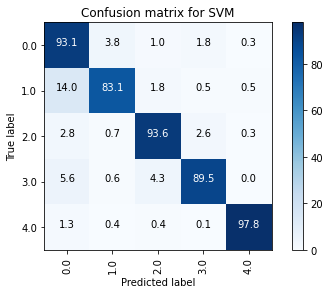

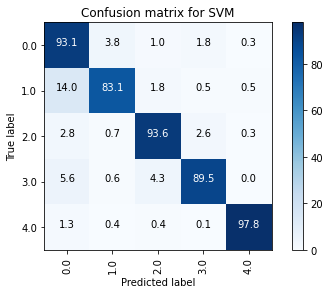

In [22]:
# check the metrics on testing dataset
mt.metrics_report(model_svm[0], 'SVM', X_test, y_test, y_train, data='test')

__[top](#Contents)__  

### SMOTE-ENN for LightGBM

Fitting 5 folds for each of 324 candidates, totalling 1620 fits
Mean cross-validated score of the best_estimator: 0.909
           Parameter Tuned value
0      boosting_type        gbdt
1       class_weight    balanced
2      learning_rate         0.5
3          max_depth          -1
4  min_child_samples          20
5       n_estimators         500
6         num_leaves          31
7          reg_alpha           0
8         reg_lambda        0.03
9          subsample           1 

              precision    recall  f1-score   support

         0.0       0.99      0.99      0.99     14579
         1.0       0.81      0.82      0.81       426
         2.0       0.93      0.96      0.94      1112
         3.0       0.83      0.82      0.82       145
         4.0       0.98      0.99      0.98      1249

    accuracy                           0.98     17511
   macro avg       0.91      0.92      0.91     17511
weighted avg       0.98      0.98      0.98     17511

Wall time: 3d 3h 51min 12s

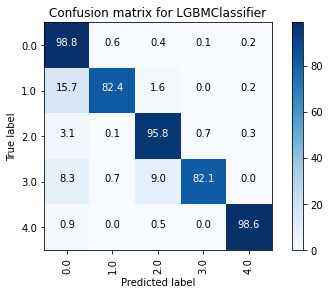

In [4]:
%%time
import lightgbm as lgb

name='LGBMClassifier'
model = lgb.LGBMClassifier(random_state=42,
                         objective='multiclass', 
                         )
 
resample=SMOTEENN(enn=EditedNearestNeighbours(sampling_strategy='all'), random_state=42)

steps=[
    ('r', resample),
]

parameters = {
    'LGBMClassifier__boosting_type': ['gbdt'],  # 'gbdt'
    'LGBMClassifier__num_leaves': [31],  # 31
    'LGBMClassifier__max_depth': [-1, 10, 50],  # -1
    'LGBMClassifier__learning_rate': [0.1, 0.05, 0.5],  # 0.1
    'LGBMClassifier__n_estimators': [100, 500],  # 100
#     'LGBMClassifier__subsample_for_bin': [200000],  # 200000
    'LGBMClassifier__class_weight': ['balanced'],  # None
#     'LGBMClassifier__min_split_gain': [0],  # 0
#     'LGBMClassifier__min_child_weight': [1e-3],  # 1e-3
    'LGBMClassifier__min_child_samples': [20],  # 20
    'LGBMClassifier__subsample': [1, 0.7],  # 1
#     'LGBMClassifier__colsample_bytree': [1],  # 1
    'LGBMClassifier__reg_alpha': [0, 0.03, 0.07],  # 0
    'LGBMClassifier__reg_lambda': [0, 0.03, 0.07],  # 0
}

model_lgbm, y_pred_lgbm = cls_models.checkmodel(
                                    name,
                                    model,
                                    steps=steps,
                                    parameters=parameters,
                                    average='macro',
                                    multiclass=True,
                                    metric='recall',
                                    randomized_search=False,
                                    nfolds=5,
                                    n_jobs=56,
                                    save_pickle=True,
                                    verbose=3
                                    )

              precision    recall  f1-score   support

         0.0       0.99      0.99      0.99     18118
         1.0       0.80      0.79      0.80       556
         2.0       0.95      0.95      0.95      1448
         3.0       0.76      0.81      0.79       162
         4.0       0.98      0.98      0.98      1608

    accuracy                           0.98     21892
   macro avg       0.90      0.91      0.90     21892
weighted avg       0.98      0.98      0.98     21892



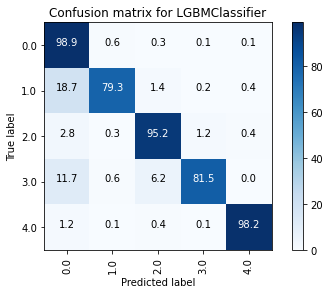

In [5]:
# check the metrics on testing dataset
mt.metrics_report(model_lgbm, 'LGBMClassifier', X_test, y_test, y_train, data='test')

__[top](#Contents)__  

### SMOTE-ENN for Random Forest

Fitting 5 folds for each of 48 candidates, totalling 240 fits
Mean cross-validated score of the best_estimator: 0.8978
                   Parameter Tuned value
0                  bootstrap        True
1               class_weight        None
2                  criterion        gini
3                  max_depth          10
4             max_leaf_nodes        None
5                max_samples        None
6      min_impurity_decrease           0
7           min_samples_leaf           1
8          min_samples_split           5
9   min_weight_fraction_leaf           0
10              n_estimators         100
11                 oob_score        True 

              precision    recall  f1-score   support

         0.0       0.99      0.95      0.97     14579
         1.0       0.56      0.83      0.67       426
         2.0       0.88      0.90      0.89      1112
         3.0       0.27      0.88      0.41       145
         4.0       0.95      0.97      0.96      1249

    accuracy        

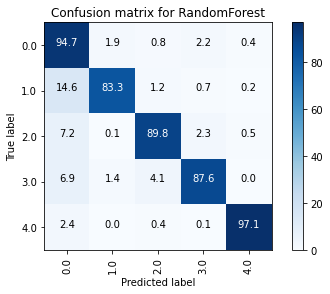

In [6]:
%%time
from sklearn.ensemble import RandomForestClassifier

name='RandomForest'
model = RandomForestClassifier(random_state=42,
#                               n_jobs=None,  # None
                              )

resample=SMOTEENN(enn=EditedNearestNeighbours(sampling_strategy='all'), random_state=42)

steps=[
    ('r', resample),
]

parameters = {
    'RandomForest__n_estimators': [100, 500],  # 100
    'RandomForest__criterion': ['gini'],  # gini
    'RandomForest__max_depth': [None, 5, 10],  # None
    'RandomForest__min_samples_split': [2, 5],  # 2
    'RandomForest__min_samples_leaf': [1, 5],  # 1
    'RandomForest__min_weight_fraction_leaf': [0],  # 0
#     'RandomForest__max_features': ['auto'],  # auto
    'RandomForest__max_leaf_nodes': [None],  # None
    'RandomForest__min_impurity_decrease': [0],  # 0
    'RandomForest__bootstrap': [True],  # True
    'RandomForest__oob_score': [True],  # False - only if bootstrap=True
    'RandomForest__max_samples': [None],  # None - if bootstrap=True
    'RandomForest__class_weight': [None, 'balanced'],  # None
}

model_rf_enn, y_pred_rf_enn = cls_models.checkmodel(
                                    name,
                                    model,
                                    steps=steps,
                                    parameters=parameters,
                                    average='macro',
                                    multiclass=True,
                                    metric='recall',
                                    randomized_search=False,
                                    nfolds=5,
                                    n_jobs=56,
                                    save_pickle=True,
                                    verbose=3
                                    )

              precision    recall  f1-score   support

         0.0       0.98      0.94      0.96     18118
         1.0       0.53      0.77      0.63       556
         2.0       0.90      0.90      0.90      1448
         3.0       0.22      0.87      0.35       162
         4.0       0.94      0.95      0.95      1608

    accuracy                           0.94     21892
   macro avg       0.72      0.89      0.76     21892
weighted avg       0.96      0.94      0.94     21892



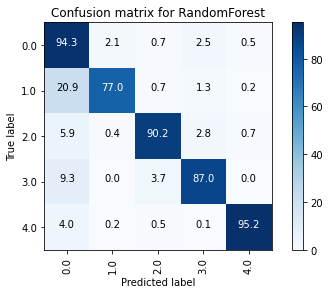

In [8]:
# check the metrics on testing dataset
mt.metrics_report(model_rf_enn, 'RandomForest', X_test, y_test, y_train, data='test')

__[top](#Contents)__  

### SMOTE-ENN for CNN

In [ ]:
name = 'CNN'

from imblearn.combine import SMOTEENN, SMOTETomek
from imblearn.under_sampling import EditedNearestNeighbours, TomekLinks
resample = SMOTEENN(enn=EditedNearestNeighbours(sampling_strategy='all'),  random_state=42)
X_train, y_train = resample.fit_resample(X_train, y_train)

X_train = np.array(X_train)
X_val = np.array(X_val)
X_test = np.array(X_test)

y_train_dummy=to_categorical(y_train)
y_val_dummy=to_categorical(y_val)
y_test_dummy=to_categorical(y_test)

X_train = X_train.reshape(len(X_train), X_train.shape[1], 1)
X_val = X_val.reshape(len(X_val), X_val.shape[1], 1)
X_test = X_test.reshape(len(X_test), X_test.shape[1], 1)

tf.random.set_seed(42)

def create_model(kernel_size=6, padding='same', strides=2, pool_size=2, lr=0.001, cl=2, cf=64, dl=2, dn=64):
    """
    """
    model = Sequential()

    # Input Layer
    model.add(Conv1D(filters=cf, kernel_size=kernel_size, activation='relu', padding=padding, input_shape=(X_train.shape[1], 1)))
    model.add(BatchNormalization()) 
    model.add(MaxPooling1D(pool_size=pool_size, strides=strides, padding=padding))

    # CNN Layers
    for i in range(cl):
        model.add(Conv1D(filters=cf, kernel_size=kernel_size, activation='relu', padding=padding))
        model.add(BatchNormalization())
        model.add(MaxPooling1D(pool_size=pool_size, strides=strides, padding=padding))

    model.add(Flatten())

    # Dense Layers
    for i in range(dl):
        model.add(Dense(units=dn, activation='relu'))

    # Output Layer
    model.add(Dense(5, activation='softmax'))  # output layer

    # loss = 'categorical_crossentropy'
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=lr),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    return model


model = KerasClassifier(build_fn=create_model, verbose=0)

params = {
    'kernel_size': [3, 6],  # 6
    'padding': ['same'],
    'strides': [1, 2],  # 2
    'pool_size': [2, 5],  # 2
    'cl': [2, 3],  # 2
    'cf': [64, 128],  # 64
    'dl': [1, 2],  # 2
    'dn': [64, 128],  # 64
}

# total fits: 75
cv = RandomizedSearchCV(
    estimator=model,
    param_distributions=params,
    cv=3,
    random_state=42,
    verbose=3,
    n_iter=25,
)

early_stopping_monitor = EarlyStopping(monitor='val_loss', patience=3)

history = History()

mc = ModelCheckpoint(f"./temp_pickle_models/{name}.h5", monitor='val_loss', save_best_only=True)

csv_logger = CSVLogger(f"log_history_{name}.csv", append=True, separator=';')

cv_results = cv.fit(X_train, y_train_dummy,
                    batch_size=32,
                    epochs=15,
                    validation_data=(X_val, y_val_dummy),
                    callbacks=[early_stopping_monitor, mc, history, csv_logger])

print(cv.best_params_)


__[top](#Contents)__  

### SMOTE-ENN for LSTM

In [ ]:
name = 'LSTM'

from imblearn.combine import SMOTEENN, SMOTETomek
from imblearn.under_sampling import EditedNearestNeighbours, TomekLinks
resample = SMOTEENN(enn=EditedNearestNeighbours(sampling_strategy='all'), random_state=42)
X_train, y_train = resample.fit_resample(X_train, y_train)

X_train = np.array(X_train)
X_val = np.array(X_val)
X_test = np.array(X_test)

y_train_dummy=to_categorical(y_train)
y_val_dummy=to_categorical(y_val)
y_test_dummy=to_categorical(y_test)

X_train = X_train.reshape(len(X_train), X_train.shape[1], 1)
X_val = X_val.reshape(len(X_val), X_val.shape[1], 1)
X_test = X_test.reshape(len(X_test), X_test.shape[1], 1)

tf.random.set_seed(42)

def create_model(lr=0.001, layers=1, units=64, dense_layers=2, dense_neurons=64):
    """
    ll - LSTM layers
    lu - LSTM units
    dl - DNN layers
    dn - DNN neurons
    """
    model = Sequential()

    # Input Layer
    model.add(LSTM(X_train.shape[1], input_shape=X_train.shape[1:], return_sequences=True))

    # LSTM Layers
    for i in range(layers):
        model.add(LSTM(units, return_sequences=True))
        model.add(Dropout(0.2))

    model.add(Flatten())

    # Dense Layers
    for i in range(dense_layers):
        model.add(Dense(units=dense_neurons, activation='relu'))

    # Output layer
    model.add(Dense(5, activation='softmax'))

    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=lr),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    return model

model = KerasClassifier(build_fn=create_model, verbose=0)

params = {
    'lr': [0.001],  # 0.001
    'layers': [2, 5],  # 5
    'units': [64, 128],  # 128
    'dense_layers': [0, 2],  # 0roc_auc_score
    'dense_neurons': [64, 128],  # 128
}

# total fits: 48
cv = RandomizedSearchCV(
    estimator=model,
    param_distributions=params,
    cv=3,
    random_state=42,
    verbose=3,
    n_iter=25,
)

early_stopping_monitor = EarlyStopping(monitor='val_loss', patience=3)

history = History()

mc = ModelCheckpoint(f"./temp_pickle_models/{name}.h5", monitor='val_loss', save_best_only=True)

csv_logger = CSVLogger(f"log_history_{name}.csv", append=True, separator=';')

cv_results = cv.fit(X_train, y_train_dummy,
                    batch_size=32,
                    epochs=15,
                    validation_data=(X_val, y_val_dummy),
                    callbacks=[early_stopping_monitor, mc,
                    history, csv_logger])

print(cv.best_params_)


__[top](#Contents)__  

### SMOTE-ENN for BLSTM

In [ ]:
from imblearn.combine import SMOTEENN, SMOTETomek
from imblearn.under_sampling import EditedNearestNeighbours, TomekLinks
resample = SMOTEENN(enn=EditedNearestNeighbours(sampling_strategy='all'), random_state=42)
X_train, y_train = resample.fit_resample(X_train, y_train)

X_train = np.array(X_train)
X_val = np.array(X_val)
X_test = np.array(X_test)

y_train_dummy=to_categorical(y_train)
y_val_dummy=to_categorical(y_val)
y_test_dummy=to_categorical(y_test)

X_train = X_train.reshape(len(X_train), X_train.shape[1], 1)
X_val = X_val.reshape(len(X_val), X_val.shape[1], 1)
X_test = X_test.reshape(len(X_test), X_test.shape[1], 1)

tf.random.set_seed(42)

name='BLSTM'

def create_model(lr=0.001, layers=1, units=64, dense_layers=2, dense_neurons=64):
    model = Sequential()

    # Input Layer
    model.add(Bidirectional(LSTM(units, return_sequences=True), input_shape=X_train.shape[1:]))

    # LSTM Layers
    for i in range(layers):
        model.add(Bidirectional(LSTM(units, return_sequences=True)))
        model.add(Dropout(0.2))

    model.add(Flatten())

    # Dense Layers
    for i in range(dense_layers):
        model.add(Dense(units=dense_neurons, activation='relu'))

    # Output layer
    model.add(Dense(5, activation='softmax'))

    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=lr),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    return model


model = KerasClassifier(build_fn=create_model, verbose=0)

params = {
    'lr': [0.001],  #
    'layers': [2, 5],  #
    'units': [64, 128],  #
    'dense_layers': [0, 2],  #
    'dense_neurons': [64, 128],  #
}

# total fits:
cv = RandomizedSearchCV(
     estimator=model,
     param_distributions=params,
     cv=3,
     random_state=42,
     verbose=3,
     n_iter=25,
 )


early_stopping_monitor = EarlyStopping(monitor='val_loss', patience=3)

history = History()

mc = ModelCheckpoint(f"./temp_pickle_models/{name}.h5", monitor='val_loss', save_best_only=True)

csv_logger = CSVLogger(f"log_history_{name}.csv", append=True, separator=';')

cv_results = cv.fit(X_train, y_train_dummy,
                    batch_size=32,
                    epochs=15,
                    validation_data=(X_val, y_val_dummy),
                    callbacks=[early_stopping_monitor, mc,
                    history, csv_logger])
print(cv.best_params_)


__[top](#Contents)__ 

# Summary of the results


## Metrics over all classes

- We use a ___macro-average___ which computes the metric independently for each class and then takes the average (hence treating all classes equally). Macro-average leads to a lower result since it doesn't account for the number of samples in the minority class.  

### Original dataset (validation)
<div class="alert-success"></div>
    
| Model                 | F1 score | Precision | Recall  | Accuracy | AUC |
|-----------------------|----------|-----------|---------|----------|-----------|
|   SVM                 | 0.8157   | 0.7602    | 0.9312  | 0.9568   | 0.9582 |
|   Light GBM           | 0.8264   | 0.7695    | 0.9142  | 0.9529   | 0.9485 |
| Random Forest         | 0.7957   | 0.7701    | 0.8810  | 0.9509   | 0.9208 |
| XGBoost               | 0.9095   | 0.9625    | 0.8681  | 0.9814   | 0.9249 |
| kNN                   | 0.8893   | 0.9254    | 0.8596  | 0.9769   | 0.9200 |
| Gradient Boosting     | 0.8581   | 0.9073    | 0.8192  | 0.9718   | 0.8967 |
| AdaBoost	            | 0.4422   | 0.4277    | 0.6269  | 0.5853   | 0.7594 |


### Original dataset (testing)
<div class="alert-success"></div>
    
| Model                 | F1 score | Precision | Recall  | Accuracy | AUC |
|-----------------------|----------|-----------|---------|----------|-----------|
| __SVM__               | 0.8043   | 0.7527    | __0.9149__  | 0.9568   | 0.9489 |
| Light GBM             | 0.8102   | 0.7513    | 0.9099  | 0.9498   | 0.9460 |
| Random Forest         | 0.7831   | 0.7611    | 0.8674  | 0.9497   | 0.9208 |
| XGBoost               | 0.8956   | 0.9576    | 0.8494  | 0.9807   | 0.9152 |
| kNN                   | 0.8767   | 0.9179    | 0.8433  | 0.9767   | 0.9117 |
| Gradient Boosting     | 0.8379   | 0.8813    | 0.8058  | 0.9691   | 0.8891 |
| AdaBoost	            | 0.4450   | 0.4303    | 0.6258  | 0.6010   | 0.7611 |


### SMOTE Tomek-Links resampling (validation)

| Model                 | F1 score | Precision | Recall  | Accuracy | AUC |
|-----------------------|----------|-----------|---------|----------|-----------|
| SVM                   | 0.7769   | 0.7194    | 0.9240  | 0.9403   | 0.9525 |
| Light GBM             | 0.8521   | 0.8116    | 0.9061  | 0.9651   | 0.9454 |
| Random Forest         | 0.7900   | 0.7491    | 0.8984  | 0.9483   | 0.9379 |


### SMOTE Tomek-Links resampling (testing)

| Model                 | F1 score | Precision | Recall  | Accuracy | AUC |
|-----------------------|----------|-----------|---------|----------|-----------|
| SVM                   | 0.7690   | 0.7130    | 0.9141  | 0.9381   | 0.9471 |
| Light GBM             | 0.8393   | 0.7966    | 0.9025  | 0.9629   | 0.9430 |
| Random Forest         | 0.7722   | 0.7379    | 0.8882  | 0.9432   | 0.9319 |


### SMOTE ENN resampling (validation) 

| Model                 | F1 score | Precision | Recall  | Accuracy | AUC |
|-----------------------|----------|-----------|---------|----------|-----------|
| SVM                   | 0.7689   | 0.7074    | 0.9276  | 0.9352   | 0.9543 |
| Light GBM             | 0.9104   | 0.9057    | 0.9153  | 0.9802   | 0.9521 |
| Random Forest         | 0.7788   | 0.7285    | 0.9051  | 0.9422   | 0.9415 |


### SMOTE ENN resampling (testing)

| Model                 | F1 score | Precision | Recall  | Accuracy | AUC |
|-----------------------|----------|-----------|---------|----------|-----------|
| SVM                   | 0.7596   | 0.7006    | 0.9144  | 0.9323   | 0.9470 |
| Light GBM             | 0.9006   | 0.8955    | 0.9061  | 0.9790   | 0.9470 |
| Random Forest         | 0.7578   | 0.7154    | 0.8874  | 0.9360   | 0.9310 |



## Metrics per class for original dataset

| Encoding | Description                               |
|----------|-------------------------------------------|
|    0     | N - Normal beat                           | 
|    1     | S - Supraventricular premature beat       | 
|    2     | V - Premature ventricular contraction     | 
|    3     | F - Fusion of ventricular and normal beat | 
|    4     | Q - Unclassifiable beat                   | 



-  __[SVM](#SVM)__  

              Parameter Tuned value
        0             C           1
        1  class_weight    balanced
        2         gamma         0.5

__Validation dataset__

                          precision    recall  f1-score   support
                     0.0       0.99      0.96      0.98     14579
                     1.0       0.55      0.86      0.67       426
                     2.0       0.91      0.94      0.92      1112
                     3.0       0.36      0.90      0.52       145
                     4.0       0.98      0.99      0.99      1249
             
                accuracy                           0.96     17511
               macro avg       0.76      0.93      0.82     17511
            weighted avg       0.97      0.96      0.96     17511
    

<p float="left">
<img src="./Reports/Original/report_validation/SVM.png" width="250"/> 
<img src="./Reports/Original/report_validation/SVM_ROC.png" width="270"/>
<img src="./Reports/Original/report_validation/SVM_PR.png" width="270"/>
</p>


__Testing dataset__  

                          precision    recall  f1-score   support
                     0.0       0.99      0.96      0.97     18118
                     1.0       0.52      0.80      0.63       556
                     2.0       0.92      0.94      0.93      1448
                     3.0       0.36      0.90      0.51       162
                     4.0       0.98      0.98      0.98      1608
             
                accuracy                           0.95     21892
               macro avg       0.75      0.91      0.80     21892
            weighted avg       0.97      0.95      0.96     21892


<p float="left">
<img src="./Reports/Original/report_test/SVM.png" width="250"/>
<img src="./Reports/Original/report_test/SVM_ROC.png" width="270"/>
<img src="./Reports/Original/report_test/SVM_PR.png" width="270"/>
</p>

> ___Since `predict_proba` may be [inconsistent](https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html#sklearn.svm.SVC) with predict, `.predict()` method is used to plot the ROC curve and Precision-Recall curve.___


- __[Light GBM](#LightGBM)__ 


                   Parameter Tuned value
        0      boosting_type        gbdt
        1       class_weight    balanced
        2      learning_rate        0.05
        3          max_depth          -1
        4  min_child_samples          20
        5       n_estimators         100
        6         num_leaves          31
        7          reg_alpha        0.07
        8         reg_lambda           0
        9          subsample           1


__Validation dataset__

                          precision    recall  f1-score   support
                     0.0       0.99      0.96      0.97     14579
                     1.0       0.52      0.85      0.64       426
                     2.0       0.85      0.94      0.89      1112
                     3.0       0.54      0.84      0.66       145
                     4.0       0.95      0.98      0.96      1249
             
                accuracy                           0.95     17511
               macro avg       0.77      0.91      0.83     17511
            weighted avg       0.96      0.95      0.96     17511
            

<p float="left">
<img src="./Reports/Original/report_validation/LightGBM.png" width="250"/>
<img src="./Reports/Original/report_validation/LightGBM_ROC.png" width="270"/>
<img src="./Reports/Original/report_validation/LightGBM_PR.png" width="270"/>
</p>


__Testing dataset__ 

                          precision    recall  f1-score   support
                     0.0       0.99      0.95      0.97     18118
                     1.0       0.50      0.82      0.62       556
                     2.0       0.86      0.95      0.90      1448
                     3.0       0.46      0.85      0.59       162
                     4.0       0.95      0.98      0.96      1608
             
                accuracy                           0.95     21892
               macro avg       0.75      0.91      0.81     21892
            weighted avg       0.96      0.95      0.95     21892


<p float="left">
<img src="./Reports/Original/report_test/LightGBM.png" width="250"/>
<img src="./Reports/Original/report_test/LightGBM_ROC.png" width="270"/>
<img src="./Reports/Original/report_test/LightGBM_PR.png" width="270"/>
</p>




- __[Random Forest](#Random-Forest)__ 


                           Parameter Tuned value
        0                  bootstrap        True
        1               class_weight    balanced
        2                  criterion        gini
        3                  max_depth          10
        4             max_leaf_nodes        None
        5                max_samples        None
        6      min_impurity_decrease           0
        7           min_samples_leaf           5
        8          min_samples_split           2
        9   min_weight_fraction_leaf           0
        10              n_estimators         100
        11                 oob_score        True


__Validation dataset__

                          precision    recall  f1-score   support
                     0.0       0.98      0.96      0.97     14579
                     1.0       0.73      0.75      0.74       426
                     2.0       0.90      0.88      0.89      1112
                     3.0       0.28      0.86      0.42       145
                     4.0       0.97      0.96      0.96      1249

                accuracy                           0.95     17511
               macro avg       0.77      0.88      0.80     17511
            weighted avg       0.96      0.95      0.96     17511


<p float="left">
<img src="./Reports/Original/report_validation/RandomForest.png" width="250"/>
<img src="./Reports/Original/report_validation/RandomForest_ROC.png" width="270"/>
<img src="./Reports/Original/report_validation/RandomForest_PR.png" width="270"/>
</p>


__Testing dataset__  

                          precision    recall  f1-score   support
                     0.0       0.98      0.96      0.97     18118
                     1.0       0.69      0.71      0.70       556
                     2.0       0.92      0.89      0.90      1448
                     3.0       0.25      0.83      0.39       162
                     4.0       0.97      0.94      0.96      1608

                accuracy                           0.95     21892
               macro avg       0.76      0.87      0.78     21892
            weighted avg       0.96      0.95      0.95     21892


<p float="left">
<img src="./Reports/Original/report_test/RandomForest.png" width="250"/>
<img src="./Reports/Original/report_test/RandomForest_ROC.png" width="270"/>
<img src="./Reports/Original/report_test/RandomForest_PR.png" width="270"/>
</p>



- __[XGBoost](#XGBoost)__ 


                    Parameter Tuned value
        0               alpha           0
        1                 eta         0.5
        2               gamma           0
        3              lambda           1
        4           max_depth          10
        5    min_child_weight         0.5
        6   num_parallel_tree           1
        7     sampling_method     uniform
        8    scale_pos_weight         0.3
        9           subsample         0.7
        10        tree_method        auto 


__Validation dataset__

                          precision    recall  f1-score   support
                     0.0       0.98      1.00      0.99     14579
                     1.0       0.96      0.70      0.81       426
                     2.0       0.96      0.92      0.94      1112
                     3.0       0.92      0.74      0.82       145
                     4.0       0.99      0.98      0.98      1249
             
                accuracy                           0.98     17511
               macro avg       0.96      0.87      0.91     17511
            weighted avg       0.98      0.98      0.98     17511     


<p float="left">
<img src="./Reports/Original/report_validation/XGBoost.png" width="250"/>
<img src="./Reports/Original/report_validation/XGBoost_ROC.png" width="270"/>
<img src="./Reports/Original/report_validation/XGBoost_PR.png" width="270"/>
</p>


__Testing dataset__  

                          precision    recall  f1-score   support
                     0.0       0.98      1.00      0.99     18118
                     1.0       0.97      0.67      0.79       556
                     2.0       0.97      0.92      0.95      1448
                     3.0       0.87      0.69      0.77       162
                     4.0       0.99      0.97      0.98      1608
             
                accuracy                           0.98     21892
               macro avg       0.96      0.85      0.90     21892
            weighted avg       0.98      0.98      0.98     21892


<p float="left">
<img src="./Reports/Original/report_test/XGBoost.png" width="250"/>
<img src="./Reports/Original/report_test/XGBoost_ROC.png" width="270"/>
<img src="./Reports/Original/report_test/XGBoost_PR.png" width="270"/>
</p>



- __[K-Nearest Neighbors](#K-Nearest-Neighbors)__ 

             Parameter Tuned value
        0  n_neighbors           4
        1            p           1
        2      weights    distance

__Validation dataset__

                          precision    recall  f1-score   support
                     0.0       0.98      0.99      0.99     14579
                     1.0       0.89      0.69      0.78       426
                     2.0       0.93      0.90      0.92      1112
                     3.0       0.83      0.73      0.78       145
                     4.0       0.99      0.98      0.98      1249
             
                accuracy                           0.98     17511
               macro avg       0.93      0.86      0.89     17511
            weighted avg       0.98      0.98      0.98     17511
            

<p float="left">
<img src="./Reports/Original/report_validation/KNN.png" width="250"/>
<img src="./Reports/Original/report_validation/KNN_ROC.png" width="270"/>
<img src="./Reports/Original/report_validation/KNN_PR.png" width="270"/>
</p>


__Testing dataset__  

                          precision    recall  f1-score   support
                     0.0       0.98      0.99      0.99     18118
                     1.0       0.88      0.67      0.76       556
                     2.0       0.95      0.92      0.93      1448
                     3.0       0.79      0.67      0.73       162
                     4.0       0.99      0.97      0.98      1608
    
                accuracy                           0.98     21892
               macro avg       0.92      0.84      0.88     21892
            weighted avg       0.98      0.98      0.98     21892


<p float="left">
<img src="./Reports/Original/report_test/KNN.png" width="250"/>
<img src="./Reports/Original/report_test/KNN_ROC.png" width="270"/>
<img src="./Reports/Original/report_test/KNN_PR.png" width="270"/>
</p>



- __[Gradient Boosting](#Gradient-Boosting)__ 


                           Parameter   Tuned value
        0                  criterion  friedman_mse
        1              learning_rate           0.1
        2                       loss      deviance
        3                  max_depth             5
        4             max_leaf_nodes          None
        5      min_impurity_decrease             0
        6           min_samples_leaf             1
        7          min_samples_split             2
        8   min_weight_fraction_leaf             0
        9               n_estimators           500
        10          n_iter_no_change             5
        11                 subsample             1
        12       validation_fraction           0.1


__Validation dataset__

                          precision    recall  f1-score   support

                     0.0       0.98      0.99      0.99     14579
                     1.0       0.89      0.65      0.75       426
                     2.0       0.94      0.87      0.90      1112
                     3.0       0.74      0.63      0.68       145
                     4.0       0.99      0.96      0.97      1249

                accuracy                           0.97     17511
               macro avg       0.91      0.82      0.86     17511
            weighted avg       0.97      0.97      0.97     17511


<p float="left">
<img src="./Reports/Original/report_validation/GradientBoost.png" width="250"/>
<img src="./Reports/Original/report_validation/GradientBoost_ROC.png" width="270"/>
<img src="./Reports/Original/report_validation/GradientBoost_PR.png" width="270"/>
</p>


__Testing dataset__  

                          precision    recall  f1-score   support
                     0.0       0.97      0.99      0.98     18118
                     1.0       0.88      0.61      0.72       556
                     2.0       0.95      0.86      0.91      1448
                     3.0       0.61      0.62      0.61       162
                     4.0       0.99      0.95      0.97      1608

                accuracy                           0.97     21892
               macro avg       0.88      0.81      0.84     21892
            weighted avg       0.97      0.97      0.97     21892    


<p float="left">
<img src="./Reports/Original/report_test/GradientBoost.png" width="250"/>
<img src="./Reports/Original/report_test/GradientBoost_ROC.png" width="270"/>
<img src="./Reports/Original/report_test/GradientBoost_PR.png" width="270"/>
</p>



- __[AdaBoost](#AdaBoost)__ 


                Parameter Tuned value
        0  base_estimator        None
        1   learning_rate           1
        2    n_estimators         500


__Validation dataset__

                          precision    recall  f1-score   support
                     0.0       0.95      0.55      0.70     14579
                     1.0       0.05      0.53      0.10       426
                     2.0       0.28      0.70      0.40      1112
                     3.0       0.16      0.46      0.23       145
                     4.0       0.69      0.89      0.78      1249
             
                accuracy                           0.59     17511
               macro avg       0.43      0.63      0.44     17511
            weighted avg       0.86      0.59      0.67     17511         
             

<p float="left">
<img src="./Reports/Original/report_validation/AdaBoost.png" width="250"/>
<img src="./Reports/Original/report_validation/AdaBoost_ROC.png" width="270"/>
<img src="./Reports/Original/report_validation/AdaBoost_PR.png" width="270"/>
</p>


__Testing dataset__  

                          precision    recall  f1-score   support
                     0.0       0.96      0.57      0.71     18118
                     1.0       0.06      0.55      0.11       556
                     2.0       0.31      0.74      0.44      1448
                     3.0       0.12      0.40      0.19       162
                     4.0       0.70      0.88      0.78      1608

                accuracy                           0.60     21892
               macro avg       0.43      0.63      0.44     21892
            weighted avg       0.87      0.60      0.68     21892


<p float="left">
<img src="./Reports/Original/report_test/AdaBoost.png" width="250"/>
<img src="./Reports/Original/report_test/AdaBoost_ROC.png" width="270"/>
<img src="./Reports/Original/report_test/AdaBoost_PR.png" width="270"/>
</p>





__[top](#Contents)__ 


    
## Metrics per class for resampled dataset


- __[SMOTE-Tomek Links for SVM](#SMOTE-Tomek-Links-for-SVM)__ 


              Parameter Tuned value
        0             C           1
        1  class_weight    balanced
        2         gamma         0.1


__Validation dataset__

                          precision    recall  f1-score   support
                     0.0       0.99      0.94      0.97     14579
                     1.0       0.45      0.85      0.59       426
                     2.0       0.89      0.92      0.90      1112
                     3.0       0.29      0.92      0.45       145
                     4.0       0.97      0.98      0.97      1249

                accuracy                           0.94     17511
               macro avg       0.72      0.92      0.78     17511
            weighted avg       0.96      0.94      0.95     17511



<p float="left">
<img src="./Reports/SMOTE Tomek-Links resampling/report_validation/SVM_tomeklinks.png" width="250"/>
<img src="./Reports/SMOTE Tomek-Links resampling/report_validation/SVM_tomeklinks_ROC.png" width="270"/>
<img src="./Reports/SMOTE Tomek-Links resampling/report_validation/SVM_tomeklinks_PR.png" width="270"/>
</p>


__Testing dataset__  

                          precision    recall  f1-score   support
                     0.0       0.99      0.94      0.96     18118
                     1.0       0.42      0.82      0.56       556
                     2.0       0.89      0.93      0.91      1448
                     3.0       0.29      0.90      0.44       162
                     4.0       0.97      0.98      0.98      1608

                accuracy                           0.94     21892
               macro avg       0.71      0.91      0.77     21892
            weighted avg       0.96      0.94      0.95     21892



<p float="left">
<img src="./Reports/SMOTE Tomek-Links resampling/report_test/SVM_tomeklinks.png" width="250"/>
<img src="./Reports/SMOTE Tomek-Links resampling/report_test/SVM_tomeklinks_ROC.png" width="270"/>
<img src="./Reports/SMOTE Tomek-Links resampling/report_test/SVM_tomeklinks_PR.png" width="270"/>
</p>



   
- __[SMOTE-Tomek Links for LightGBM](#SMOTE-Tomek-Links-for-LightGBM)__ 


                   Parameter Tuned value
        0      boosting_type        gbdt
        1       class_weight         balanced
        2      learning_rate         0.05
        3          max_depth          10
        4  min_child_samples          20
        5       n_estimators         100
        6         num_leaves          31
        7          reg_alpha        0.07
        8         reg_lambda        0.03
        9          subsample         0.7


__Validation dataset__
  
                          precision    recall  f1-score   support
                     0.0       0.99      0.97      0.98     14579
                     1.0       0.60      0.82      0.69       426
                     2.0       0.89      0.94      0.92      1112
                     3.0       0.60      0.81      0.69       145
                     4.0       0.98      0.98      0.98      1249

                accuracy                           0.97     17511
               macro avg       0.81      0.91      0.85     17511
            weighted avg       0.97      0.97      0.97     17511


<p float="left">
<img src="./Reports/SMOTE Tomek-Links resampling/report_validation/LightGBM_tomeklinks.png" width="250"/>
<img src="./Reports/SMOTE Tomek-Links resampling/report_validation/LightGBM_tomeklinks_ROC.png" width="270"/>
<img src="./Reports/SMOTE Tomek-Links resampling/report_validation/LightGBM_tomeklinks_PR.png" width="270"/>
</p>


__Testing dataset__  


                          precision    recall  f1-score   support
                     0.0       0.99      0.94      0.97     18118
                     1.0       0.41      0.82      0.54       556
                     2.0       0.91      0.93      0.92      1448
                     3.0       0.38      0.86      0.53       162
                     4.0       0.97      0.98      0.97      1608

                accuracy                           0.94     21892
               macro avg       0.73      0.91      0.79     21892
            weighted avg       0.96      0.94      0.95     21892



<p float="left">
<img src="./Reports/SMOTE Tomek-Links resampling/report_test/LightGBM_tomeklinks.png" width="250"/>
<img src="./Reports/SMOTE Tomek-Links resampling/report_test/LightGBM_tomeklinks_ROC.png" width="270"/>
<img src="./Reports/SMOTE Tomek-Links resampling/report_test/LightGBM_tomeklinks_PR.png" width="270"/>
</p>


- __[SMOTE Tomek-Links for Random Forest](#SMOTE-Tomek-Links-for-Random-Forest)__ 


                           Parameter Tuned value
        0                  bootstrap        True
        1               class_weight        None
        2                  criterion        gini
        3                  max_depth          10
        4             max_leaf_nodes        None
        5                max_samples        None
        6      min_impurity_decrease           0
        7           min_samples_leaf           1
        8          min_samples_split           2
        9   min_weight_fraction_leaf           0
        10              n_estimators         500
        11                 oob_score        True 

    
__Validation dataset__


                      precision    recall  f1-score   support
                 0.0       0.99      0.96      0.97     14579
                 1.0       0.62      0.81      0.71       426
                 2.0       0.90      0.89      0.90      1112
                 3.0       0.27      0.86      0.41       145
                 4.0       0.96      0.96      0.96      1249

            accuracy                           0.95     17511
           macro avg       0.75      0.90      0.79     17511
        weighted avg       0.96      0.95      0.95     17511


<p float="left">
<img src="./Reports/SMOTE Tomek-Links resampling/report_validation/RandomForest_tomeklinks.png" width="250"/>
<img src="./Reports/SMOTE Tomek-Links resampling/report_validation/RandomForest_tomeklinks_ROC.png" width="270"/>
<img src="./Reports/SMOTE Tomek-Links resampling/report_validation/RandomForest_tomeklinks_PR.png" width="270"/>
</p>


__Testing dataset__  


                          precision    recall  f1-score   support
                     0.0       0.98      0.95      0.97     18118
                     1.0       0.60      0.76      0.67       556
                     2.0       0.92      0.90      0.91      1448
                     3.0       0.22      0.87      0.35       162
                     4.0       0.96      0.95      0.96      1608

                accuracy                           0.94     21892
               macro avg       0.74      0.89      0.77     21892
            weighted avg       0.96      0.94      0.95     21892

<p float="left">
<img src="./Reports/SMOTE Tomek-Links resampling/report_test/RandomForest_tomeklinks.png" width="250"/>
<img src="./Reports/SMOTE Tomek-Links resampling/report_test/RandomForest_tomeklinks_ROC.png" width="270"/>
<img src="./Reports/SMOTE Tomek-Links resampling/report_test/RandomForest_tomeklinks_PR.png" width="270"/>
</p>


- __[SMOTE-ENN for SVM](#SMOTE-ENN-for-SVM)__ 


              Parameter Tuned value
        0             C           1
        1  class_weight    balanced
        2         gamma         0.1 


__Validation dataset__


                          precision    recall  f1-score   support
                     0.0       0.99      0.93      0.96     14579
                     1.0       0.43      0.87      0.57       426
                     2.0       0.86      0.93      0.89      1112
                     3.0       0.29      0.92      0.44       145
                     4.0       0.97      0.98      0.97      1249

                accuracy                           0.94     17511
               macro avg       0.71      0.93      0.77     17511
            weighted avg       0.96      0.94      0.94     17511



<p float="left">
<img src="./Reports/SMOTE ENN resampling/report_validation/SVM_smoteenn.png" width="250"/>
<img src="./Reports/SMOTE ENN resampling/report_validation/SVM_smoteenn_ROC.png" width="270"/>
<img src="./Reports/SMOTE ENN resampling/report_validation/SVM_smoteenn_PR.png" width="270"/>
</p>

   
__Testing dataset__  
    

                          precision    recall  f1-score   support
                     0.0       0.99      0.93      0.96     18118
                     1.0       0.40      0.83      0.54       556
                     2.0       0.87      0.94      0.90      1448
                     3.0       0.28      0.90      0.43       162
                     4.0       0.97      0.98      0.97      1608

                accuracy                           0.93     21892
               macro avg       0.70      0.91      0.76     21892
            weighted avg       0.96      0.93      0.94     21892


<p float="left">
<img src="./Reports/SMOTE ENN resampling/report_test/SVM_smoteenn.png" width="250"/>
<img src="./Reports/SMOTE ENN resampling/report_test/SVM_smoteenn_ROC.png" width="270"/>
<img src="./Reports/SMOTE ENN resampling/report_test/SVM_smoteenn_PR.png" width="270"/>
</p>

    
- __[SMOTE-ENN for LightGBM](#SMOTE-ENN-for-LightGBM)__ 


                   Parameter Tuned value
        0      boosting_type        gbdt
        1       class_weight    balanced
        2      learning_rate         0.5
        3          max_depth          -1
        4  min_child_samples          20
        5       n_estimators         500
        6         num_leaves          31
        7          reg_alpha           0
        8         reg_lambda        0.03
        9          subsample           1 

    
__Validation dataset__


                          precision    recall  f1-score   support
                     0.0       0.99      0.99      0.99     14579
                     1.0       0.81      0.82      0.81       426
                     2.0       0.93      0.96      0.94      1112
                     3.0       0.83      0.82      0.82       145
                     4.0       0.98      0.99      0.98      1249

                accuracy                           0.98     17511
               macro avg       0.91      0.92      0.91     17511
            weighted avg       0.98      0.98      0.98     17511



<p float="left">
<img src="./Reports/SMOTE ENN resampling/report_validation/LightGBM_smoteenn.png" width="250"/>
<img src="./Reports/SMOTE ENN resampling/report_validation/LightGBM_smoteenn_ROC.png" width="270"/>
<img src="./Reports/SMOTE ENN resampling/report_validation/LightGBM_smoteenn_PR.png" width="270"/>
</p>


__Testing dataset__  


                          precision    recall  f1-score   support
                     0.0       0.99      0.99      0.99     18118
                     1.0       0.80      0.79      0.80       556
                     2.0       0.95      0.95      0.95      1448
                     3.0       0.76      0.81      0.79       162
                     4.0       0.98      0.98      0.98      1608

                accuracy                           0.98     21892
               macro avg       0.90      0.91      0.90     21892
            weighted avg       0.98      0.98      0.98     21892




<p float="left">
<img src="./Reports/SMOTE ENN resampling/report_test/LightGBM_smoteenn.png" width="250"/>
<img src="./Reports/SMOTE ENN resampling/report_test/LightGBM_smoteenn_ROC.png" width="270"/>
<img src="./Reports/SMOTE ENN resampling/report_test/LightGBM_smoteenn_PR.png" width="270"/>
</p>


- __[SMOTE-ENN for Random Forest](#SMOTE-ENN-for-Random-Forest)__ 


                           Parameter Tuned value
        0                  bootstrap        True
        1               class_weight        None
        2                  criterion        gini
        3                  max_depth          10
        4             max_leaf_nodes        None
        5                max_samples        None
        6      min_impurity_decrease           0
        7           min_samples_leaf           1
        8          min_samples_split           5
        9   min_weight_fraction_leaf           0
        10              n_estimators         100
        11                 oob_score        True 

    
__Validation dataset__


                      precision    recall  f1-score   support
                 0.0       0.99      0.95      0.97     14579
                 1.0       0.56      0.83      0.67       426
                 2.0       0.88      0.90      0.89      1112
                 3.0       0.27      0.88      0.41       145
                 4.0       0.95      0.97      0.96      1249

            accuracy                           0.94     17511
           macro avg       0.73      0.91      0.78     17511
        weighted avg       0.96      0.94      0.95     17511


<p float="left">
<img src="./Reports/SMOTE ENN resampling/report_validation/RandomForest_smoteenn.png" width="250"/>
<img src="./Reports/SMOTE ENN resampling/report_validation/RandomForest_smoteenn_ROC.png" width="270"/>
<img src="./Reports/SMOTE ENN resampling/report_validation/RandomForest_smoteenn_PR.png" width="270"/>
</p>


__Testing dataset__  


                          precision    recall  f1-score   support
                     0.0       0.98      0.94      0.96     18118
                     1.0       0.53      0.77      0.63       556
                     2.0       0.90      0.90      0.90      1448
                     3.0       0.22      0.87      0.35       162
                     4.0       0.94      0.95      0.95      1608

                accuracy                           0.94     21892
               macro avg       0.72      0.89      0.76     21892
            weighted avg       0.96      0.94      0.94     21892


<p float="left">
<img src="./Reports/SMOTE ENN resampling/report_test/RandomForest_smoteenn.png" width="250"/>
<img src="./Reports/SMOTE ENN resampling/report_test/RandomForest_smoteenn_ROC.png" width="270"/>
<img src="./Reports/SMOTE ENN resampling/report_test/RandomForest_smoteenn_PR.png" width="270"/>
</p>


__[top](#Contents)__  

In [9]:
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, auc
import pickle
reload(mt)
y_test_dummy = np.array(pd.get_dummies(y_test))
y_val_dummy = np.array(pd.get_dummies(y_val))
y_train_dummy = np.array(pd.get_dummies(y_train))

# lst_models = ['LightGBM', 'AdaBoost', 'GradientBoost', 'KNN', 'RandomForest', 'XGBoost', 'SVM']
lst_models = ['SVM']
# lst_models = ['LightGBM', 'SVM']
# folder = "./Reports/SMOTE Tomek-Links resampling/pickle_models/"
# folder = "./Reports/SMOTE ENN resampling/pickle_models/"
folder = "./Reports/Original/pickle_models/"

roc = mt.ROCcurve_multiclass
pr = mt.PR_multiclass
cm = mt.metrics_report

from keras.models import load_model
for name in lst_models:
    loaded_model = pickle.load(open(f"{folder}{name}.sav", 'rb'))
#     loaded_model = load_model(f"{folder}{name}.sav")
#     loaded_model = pickle.load(open(f"{folder}{name}.sav", 'rb'))
    y_pred = loaded_model.predict(X_val)
    y_pred = np.argmax(y_pred, axis=1)
    print(f"======================{name}======================")
    # F1 = 2 * (precision * recall) / (precision + recall)
    f1s = metrics.f1_score(y_val, y_pred, average='macro')
    print(f"F1-score: {round(f1s, 4)}")
    precision = metrics.precision_score(y_val, y_pred, average='macro')
    print(f"precision: {round(precision, 4)}")
    recall = metrics.recall_score(y_val, y_pred, average='macro')
    print(f"recall: {round(recall, 4)}")
    # set of labels predicted for a sample must exactly match the corresponding set of labels in y_true
    accuracy = metrics.accuracy_score(y_val, y_pred)
    print(f"ACCURACY: {round(accuracy, 4)}")
    y_pred_dummy = np.array(pd.get_dummies(y_pred))
    y_val_dummy = np.array(pd.get_dummies(y_val))
    print(f"ROC-AUC score: {round(roc_auc_score(y_val_dummy, y_pred_dummy, average='macro'), 4)}")
    
    print(f"============================================")
    print('TESTING')
    print(f"============================================")
   
    f1s = metrics.f1_score(y_test, y_pred, average='macro')
    print(f"F1-score: {round(f1s, 4)}")
    precision = metrics.precision_score(y_test, y_pred, average='macro')
    print(f"precision: {round(precision, 4)}")
    recall = metrics.recall_score(y_test, y_pred, average='macro')
    print(f"recall: {round(recall, 4)}")
    # set of labels predicted for a sample must exactly match the corresponding set of labels in y_true
    accuracy = metrics.accuracy_score(y_test, y_pred)
    print(f"ACCURACY: {round(accuracy, 4)}")
    y_pred_dummy = np.array(pd.get_dummies(y_pred))
    y_test_dummy = np.array(pd.get_dummies(y_test))
    print(f"ROC-AUC score: {round(roc_auc_score(y_test_dummy, y_pred_dummy, average='macro'), 4)}")
    


AxisError: axis 1 is out of bounds for array of dimension 1

# TO DO

- Fine tuning

__[top](#Contents)__  